In [36]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [37]:
# 1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tkSorted = th.Thicket.from_caliperreader(glob("./results/Sorted/*.cali"));
tkRandom = th.Thicket.from_caliperreader(glob("./results/Random/*.cali"));
tkReverse = th.Thicket.from_caliperreader(glob("./results/ReverseSorted/*.cali"));
tkPerturbed = th.Thicket.from_caliperreader(glob("./results/1_perc_perturbed/*.cali"));

tkSingle = th.Thicket.from_caliperreader(glob(f"./results/Sorted/p2_a{2**16}_t0.cali"));

(1/2) Reading Files: 100%|██████████| 1/1 [00:00<00:00, 36.06it/s]
0it [00:00, ?it/s]


In [38]:
print(tkSingle.tree(metric_column="Avg time/rank", precision=5))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.32256 main
├─ 0.00003 MPI_Init
├─ 0.00054 data_init_X
├─ 0.01535 comp
│  ├─ 0.00309 comp_small
│  └─ 0.01216 comp_large
├─ 0.00511 comm
│  ├─ 0.00333 comm_small
│  │  ├─ 0.00298 MPI_Allreduce
│  │  ├─ 0.00004 MPI_Isend
│  │  └─ 0.00007 MPI_Recv
│  ├─ 0.00157 comm_large
│  │  ├─ 0.00012 MPI_Allgather
│  │  ├─ 0.00071 MPI_Irecv
│  │  ├─ 0.00015 MPI_Isend
│  │  └─ 0.00014 MPI_Waitall
│  └─ 0.00010 MPI_Barrier
├─ 0.00020 correctness_check
│  ├─ 0.00002 MPI_Send
│  ├─ 0.00002 MPI_Recv
│  └─ 0.00001 MPI_Barrier
├─ 0.00001 MPI_Finalize
├─ 0.00001 MPI_Initialized
├─ 0.00001 MPI_Finalized
└─ 0.00011 MPI_Comm_dup

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.32 indices: {'profile': 3996472531})
█ 0.29 - 0.32
█ 0.23 - 0.29
█ 0.16 - 0.23
█ 0.10 - 0.16
█ 0.03 - 0.10
█ 0.00 - 0.03

name User code    ◀  Only in l

In [39]:
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512]#, 1024]
sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
measurements = ['Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']

tkRandom.metadata_column_to_perfdata("n_procs")
tkRandom.metadata_column_to_perfdata("input_size")

tkRandom.dataframe = tkRandom.dataframe.reset_index().set_index(["node", "n_procs", "input_size"]).sort_index()

tkSorted.metadata_column_to_perfdata("n_procs")
tkSorted.metadata_column_to_perfdata("input_size")

tkSorted.dataframe = tkSorted.dataframe.reset_index().set_index(["node", "n_procs", "input_size"]).sort_index()

tkReverse.metadata_column_to_perfdata("n_procs")
tkReverse.metadata_column_to_perfdata("input_size")

tkReverse.dataframe = tkReverse.dataframe.reset_index().set_index(["node", "n_procs", "input_size"]).sort_index()

tkPerturbed.metadata_column_to_perfdata("n_procs")
tkPerturbed.metadata_column_to_perfdata("input_size")

tkPerturbed.dataframe = tkPerturbed.dataframe.reset_index().set_index(["node", "n_procs", "input_size"]).sort_index()

In [40]:
speedup_measurement = 'Avg time/rank'
def transform_df(df, arr):
    arr['speedup'] = {}
    for node in df.graph.traverse():
        node_str = str(node)
        name = node_str[node_str.index(':') + 3: node_str.index(',') - 1]

        arr[name] = {}
        temp = arr[name]
        for size in sizes:
            temp[size] = {}
            
            if (name == 'main'):
                arr['speedup'][size] = {}
            
            for measurement in measurements:
                temp[size][measurement] = []
                
                if (name == 'main' and measurement == speedup_measurement):
                    arr['speedup'][size][measurement] = []

                for proc in processes:
                    temp[size][measurement].append(df.dataframe.loc[node].loc[proc].loc[size][measurement])
                    
                    if (name == 'main' and measurement == speedup_measurement):
                        arr['speedup'][size][measurement].append(df.dataframe.loc[node].loc[1].loc[size][measurement] / df.dataframe.loc[node].loc[proc].loc[size][measurement])
      
    
in_order = {}            
random = {}
reverse = {}
pert = {}

transform_df(tkSorted, in_order)
transform_df(tkRandom, random)
transform_df(tkReverse, reverse)
transform_df(tkPerturbed, pert)


{'Avg time/rank': [0.8910005991611745, 0.44514956759653124, 0.43959903157434205, 0.3857465623192316, 0.18765529312148482, 0.18587675171914247, 0.17626218626840906, 0.10695158705243403, 0.1536898567050957]}


In [41]:
def plot(arrays, names, title):
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.xscale("log", base=2)
    plt.xticks(processes)
    for name in names:
        ax.plot(processes, arrays[name], marker='o', label=name)
    ax.set_title(f'{title}')
    ax.set_xlabel('Number of Processes')
    ax.set_ylabel('Time (s)')
    ax.legend()
    fig.patch.set_alpha(1.0)
    ax.patch.set_alpha(1.0)
    plt.savefig(title.replace(' ', '_'), bbox_inches='tight')



/tmp/job.11809147/ipykernel_22758/223728676.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15, 7))


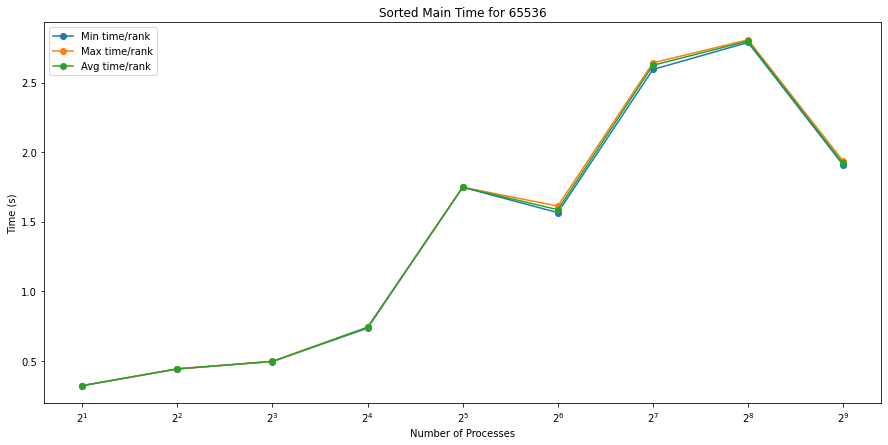

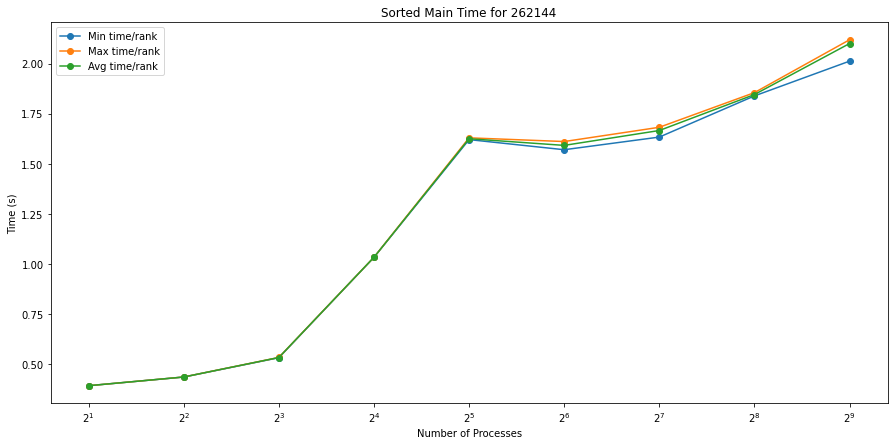

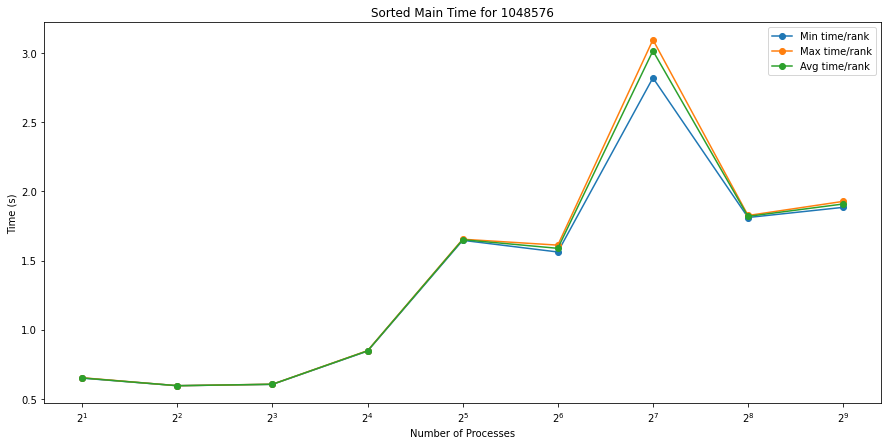

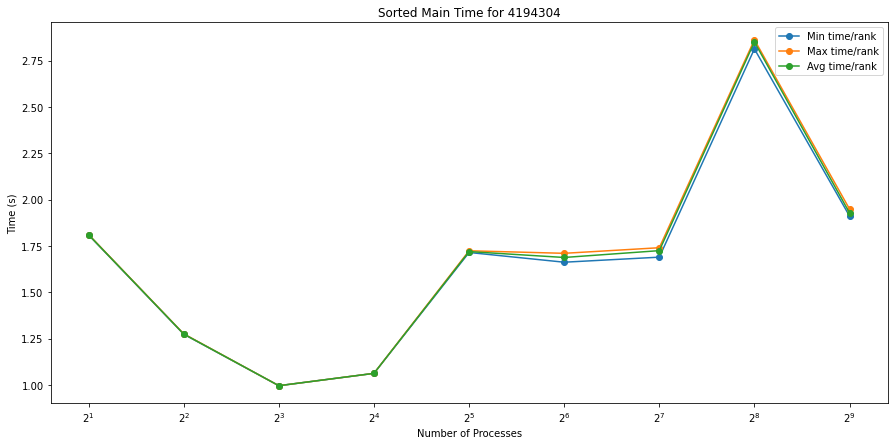

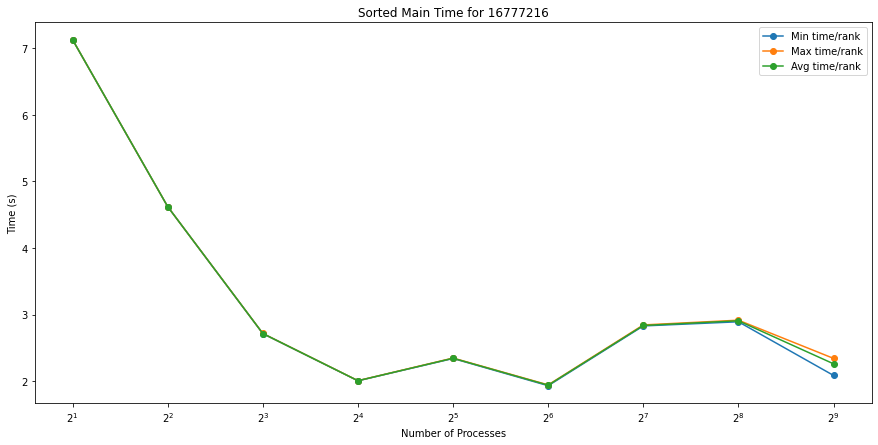

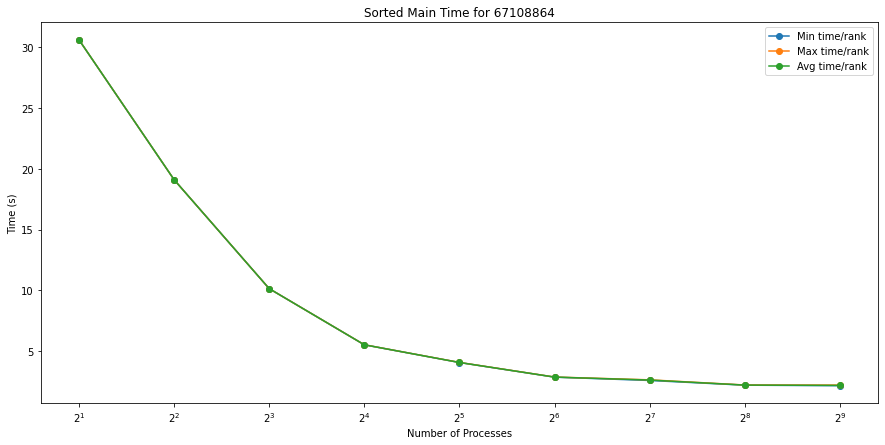

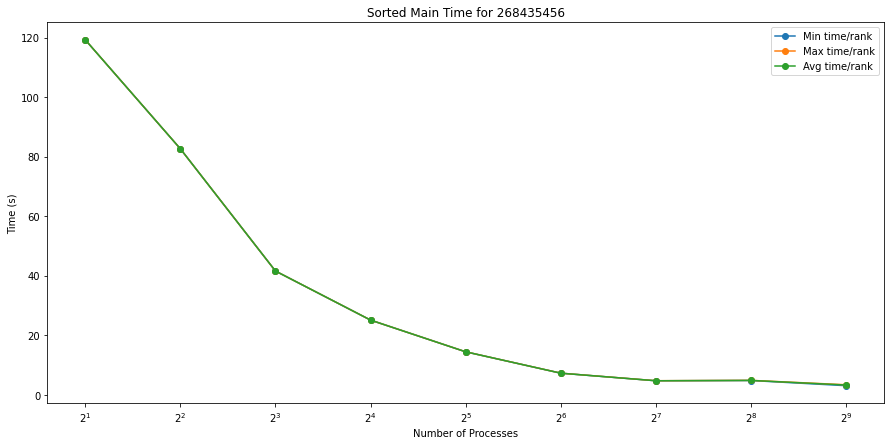

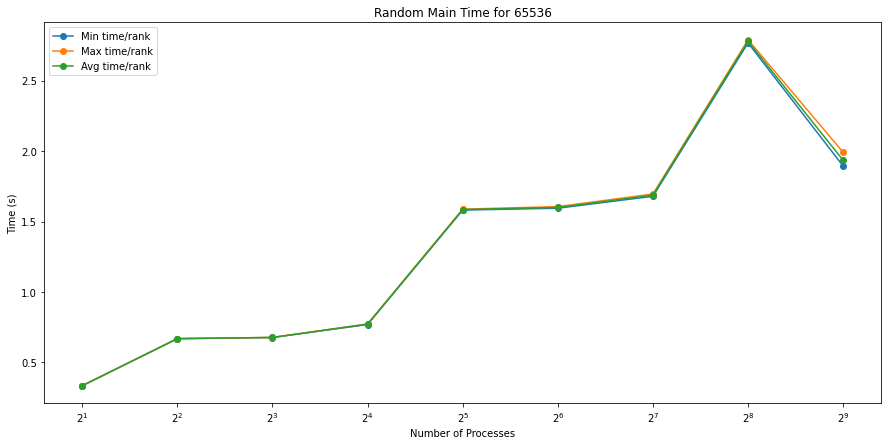

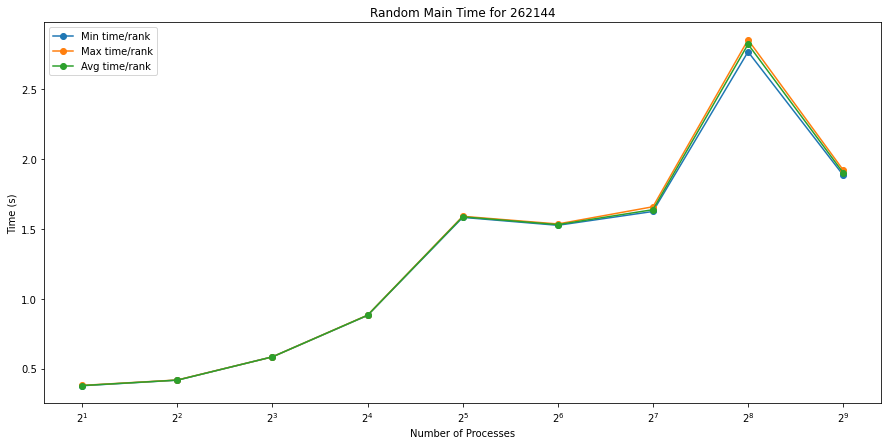

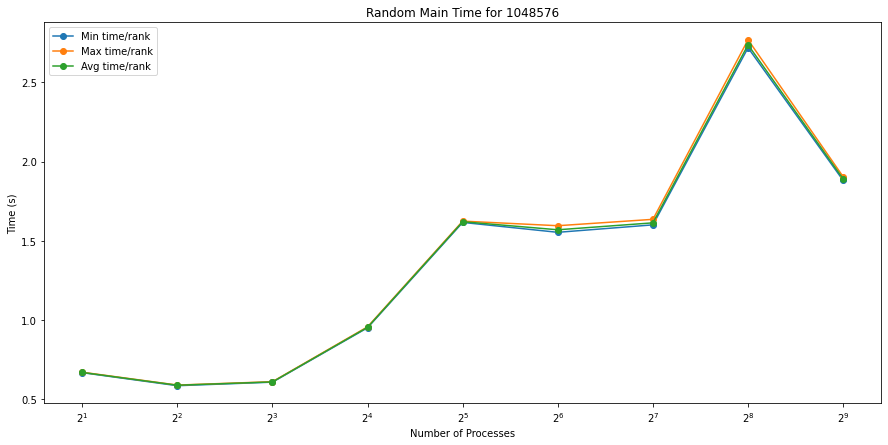

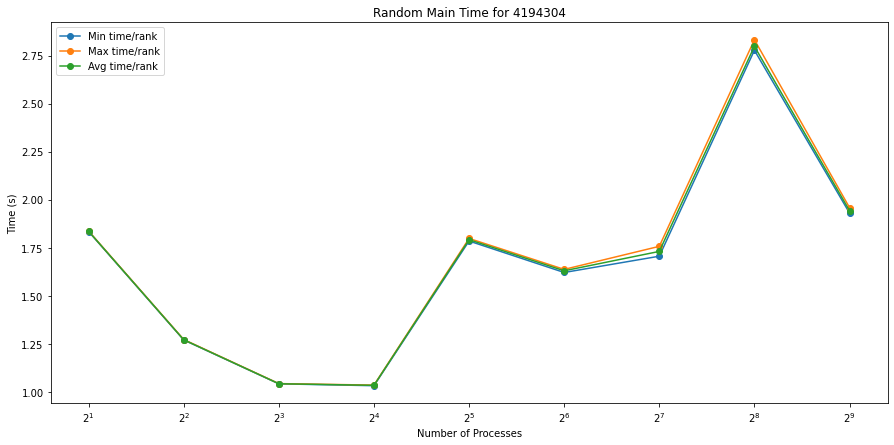

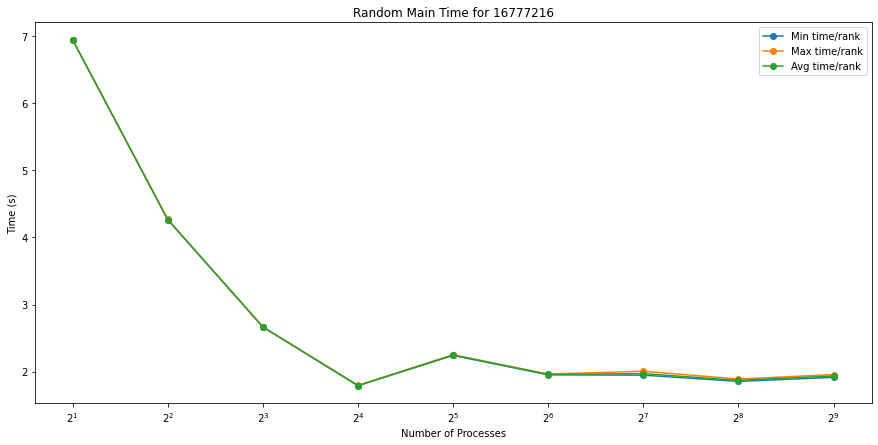

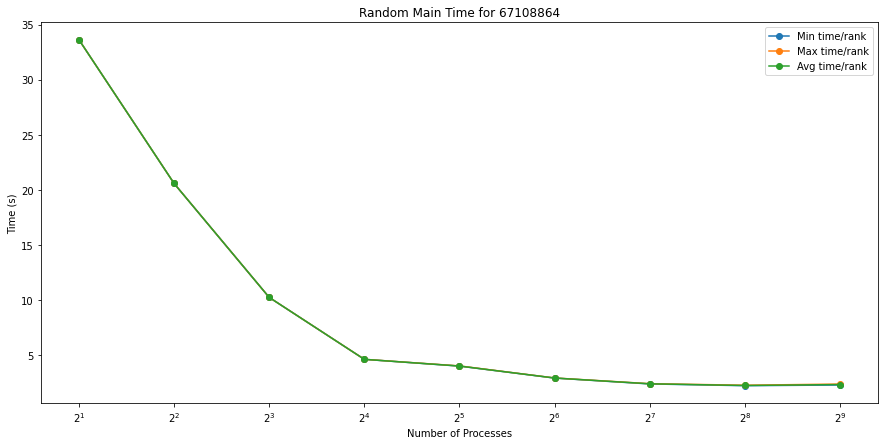

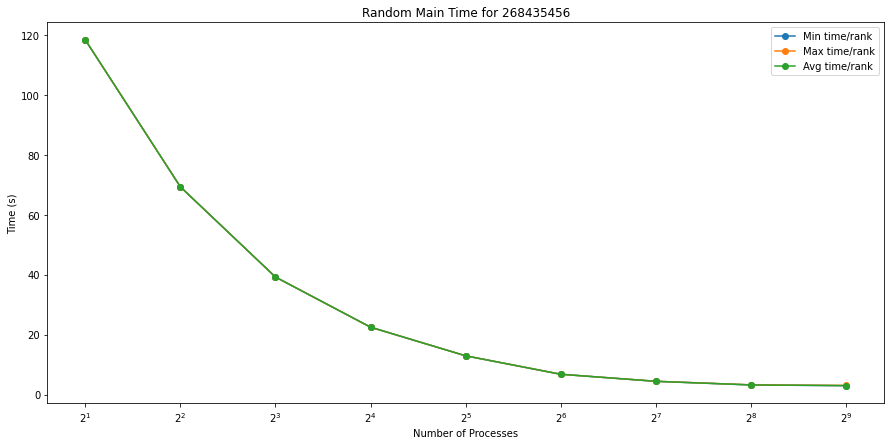

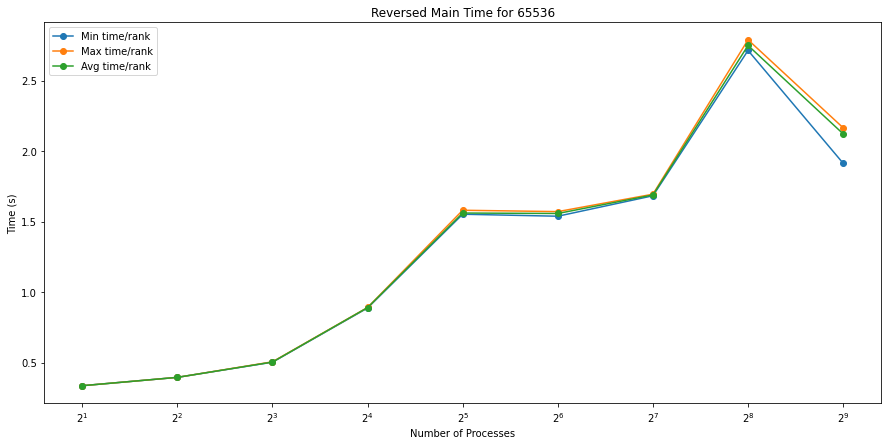

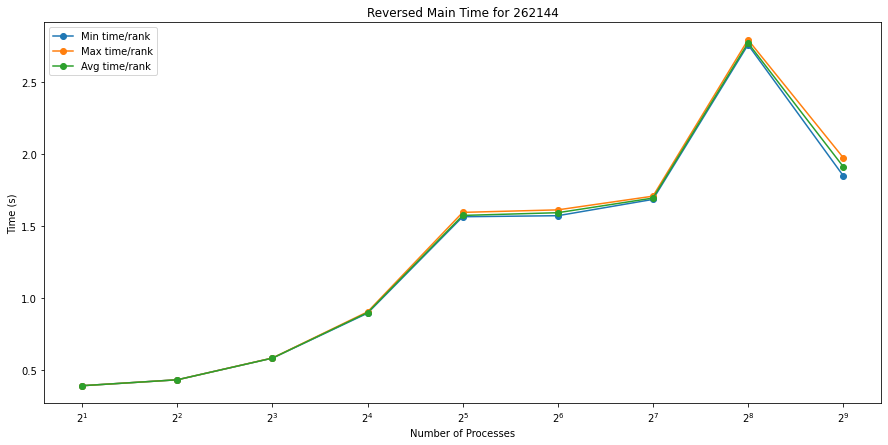

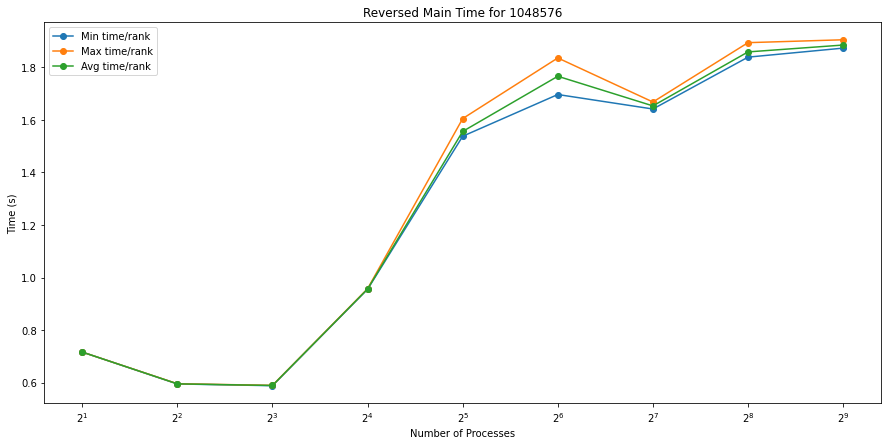

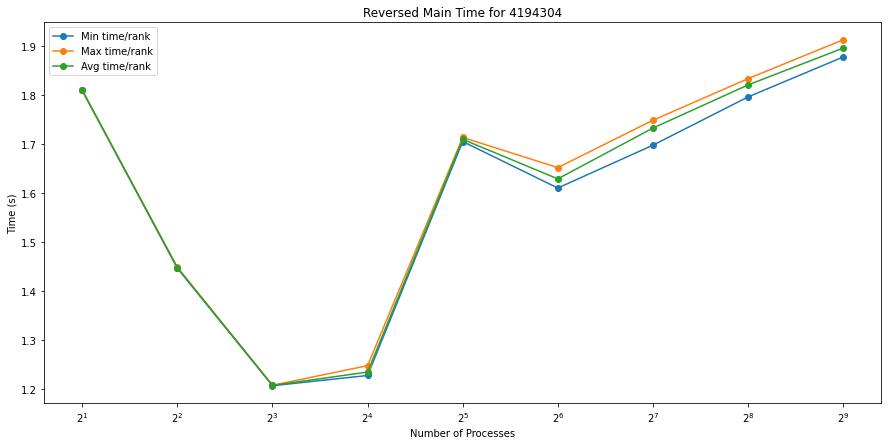

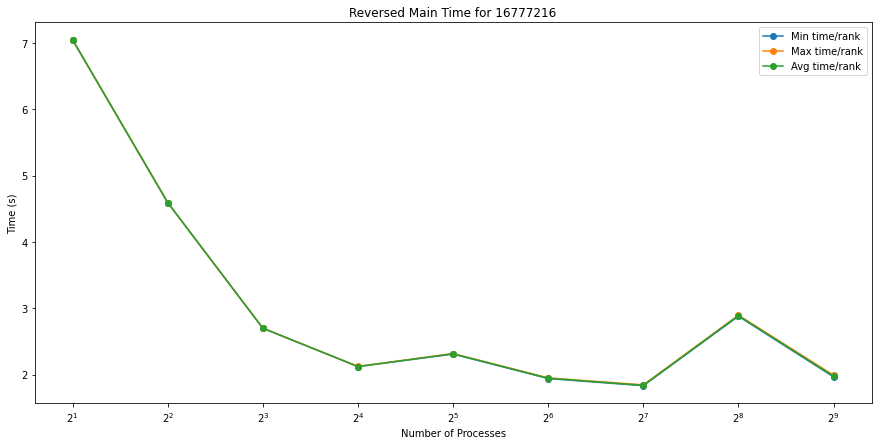

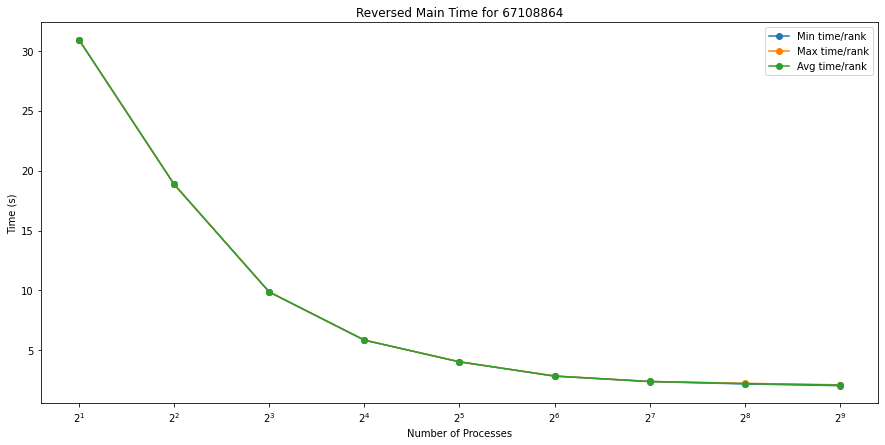

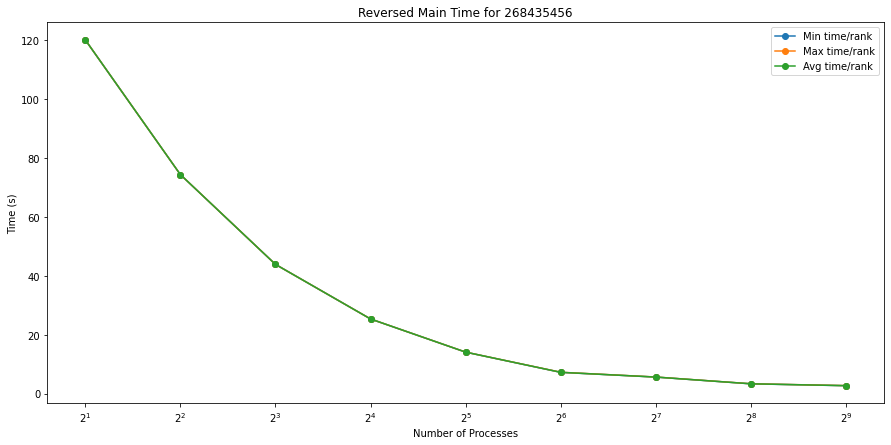

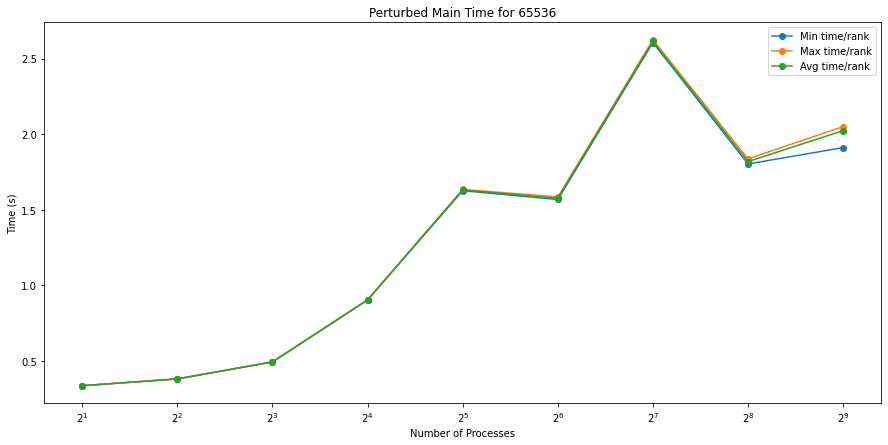

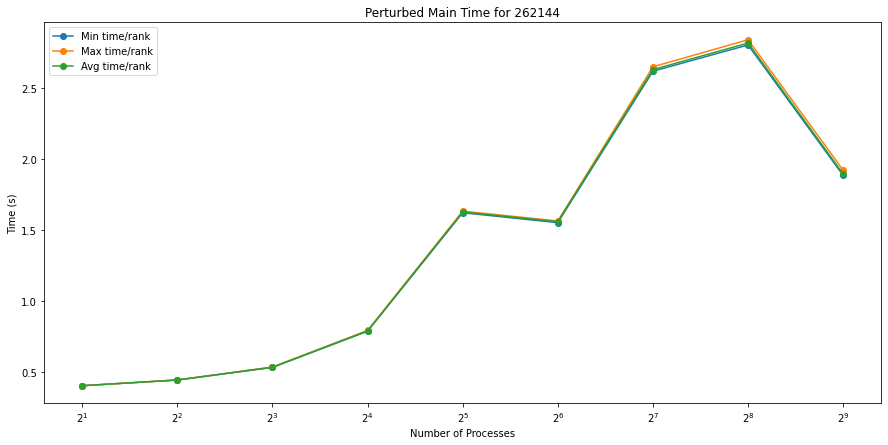

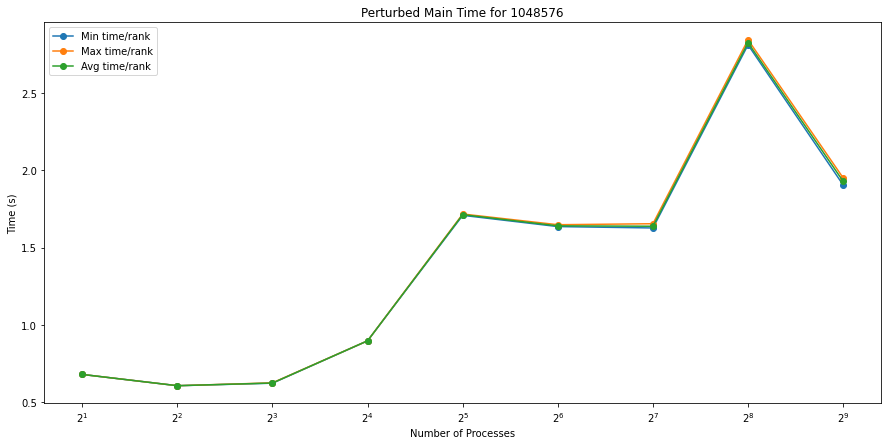

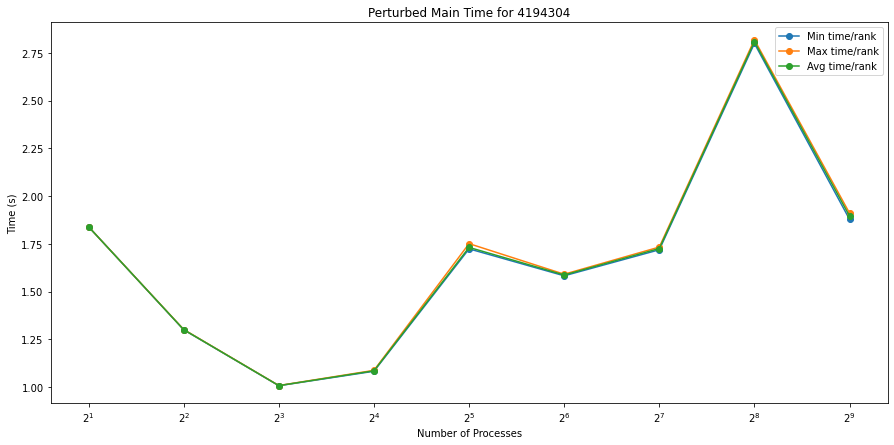

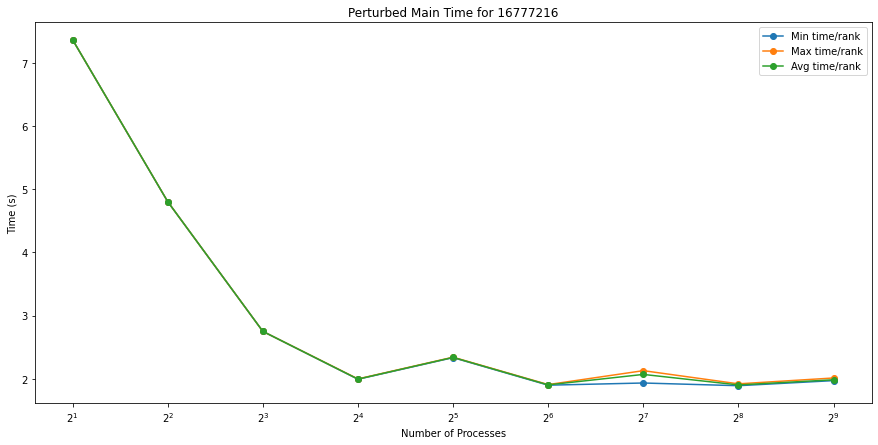

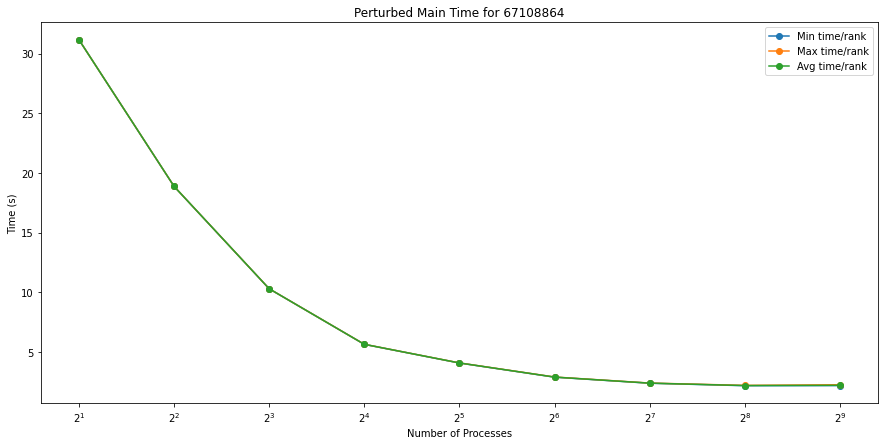

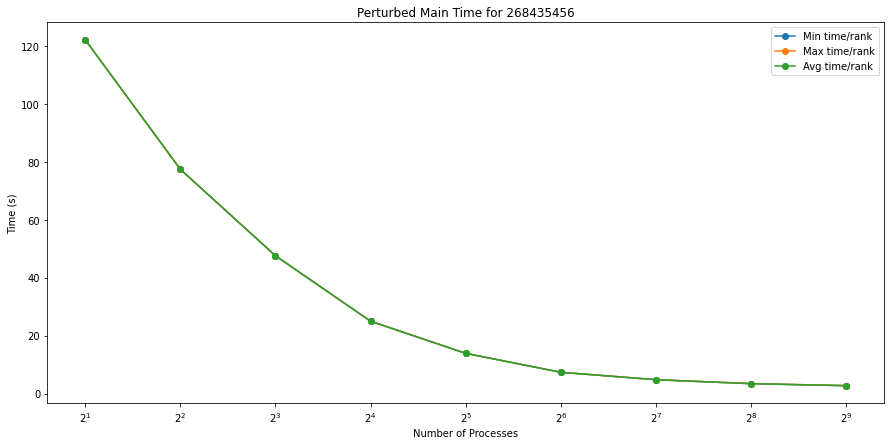

In [43]:
# Main Time
#Sorted
for size in sizes:
    plot(in_order['main'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Sorted Main Time for {size}')

# Random
for size in sizes:
    plot(random['main'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Random Main Time for {size}')

# Reversed
for size in sizes:
    plot(reverse['main'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Reversed Main Time for {size}')
    
# Perturbed
for size in sizes:
    plot(pert['main'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Perturbed Main Time for {size}')

/tmp/job.11791231/ipykernel_4499/1250125561.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15, 7))


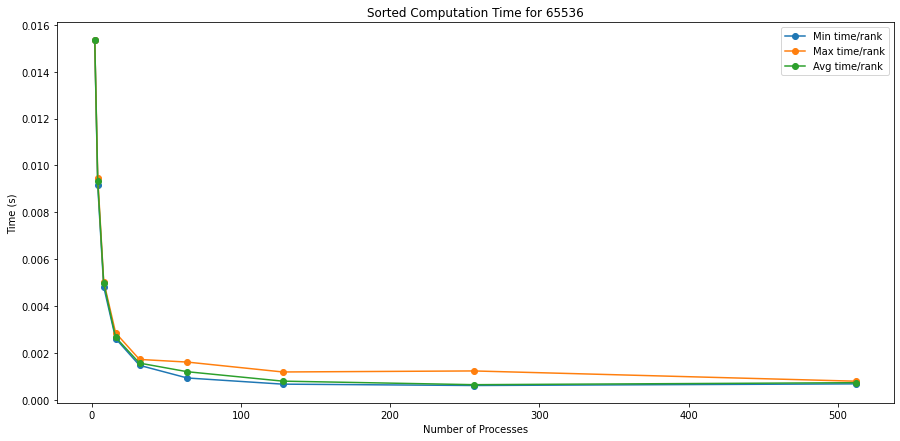

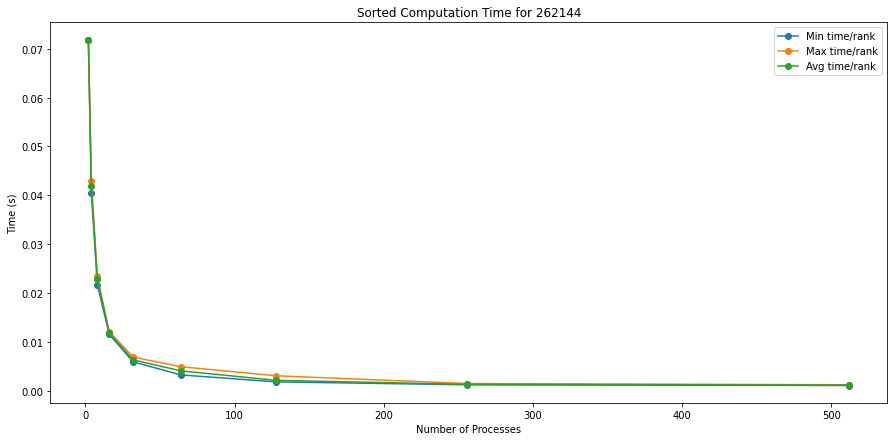

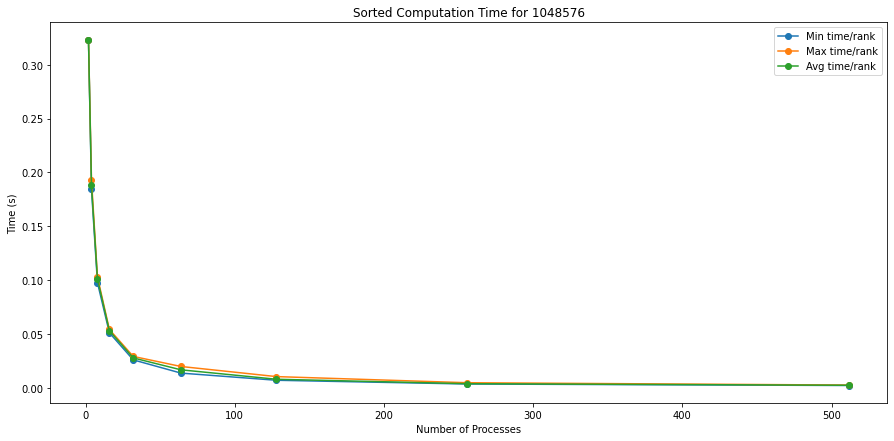

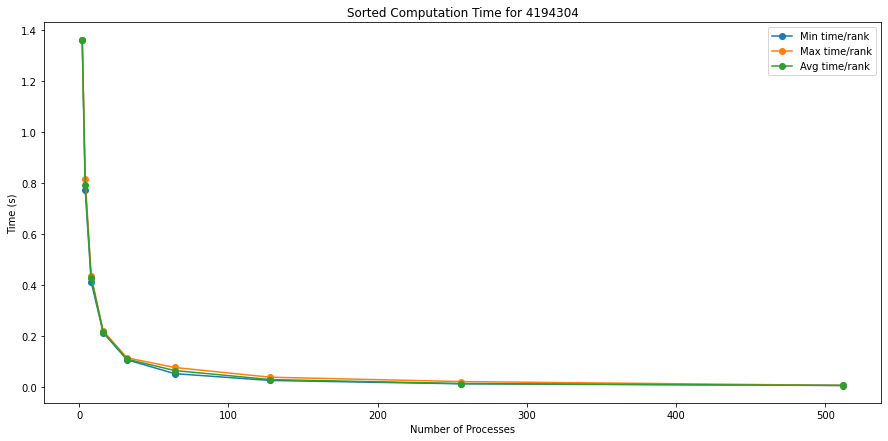

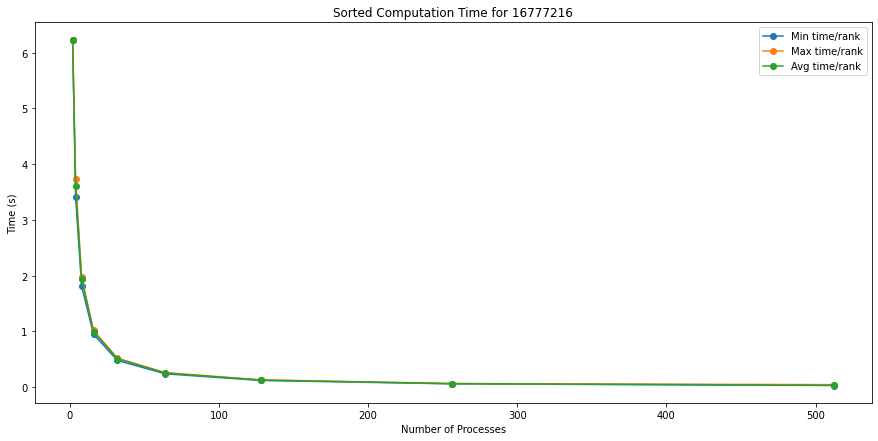

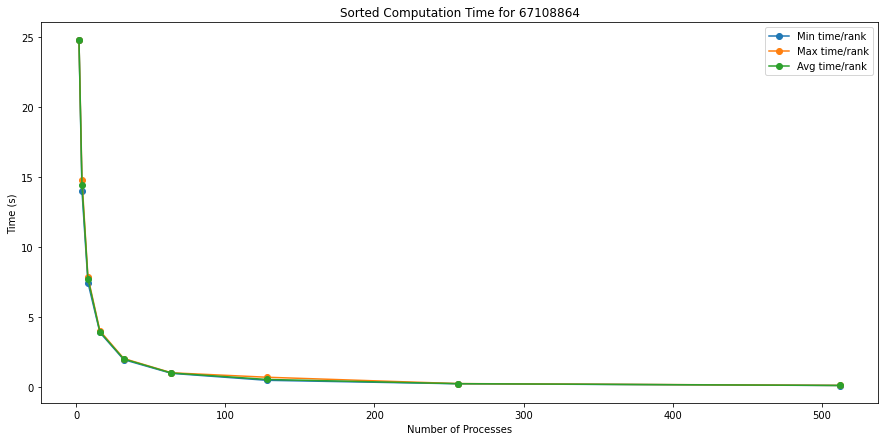

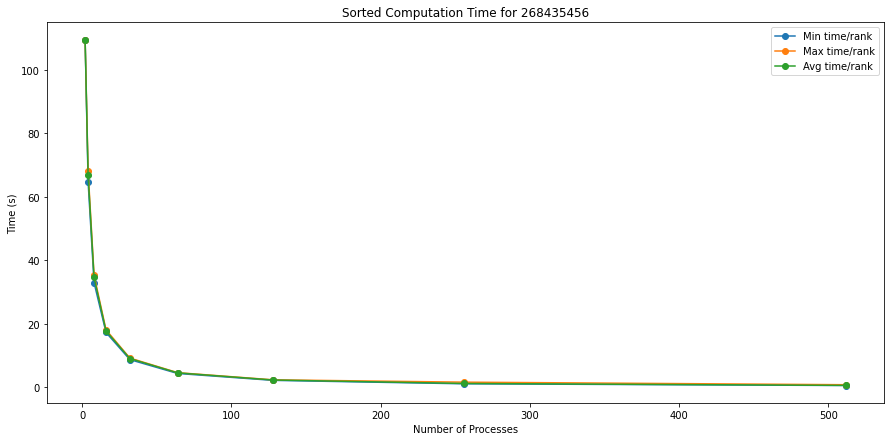

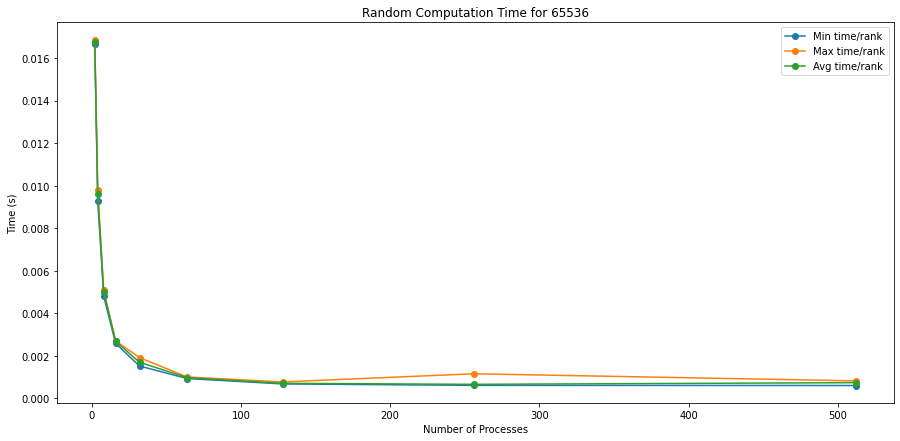

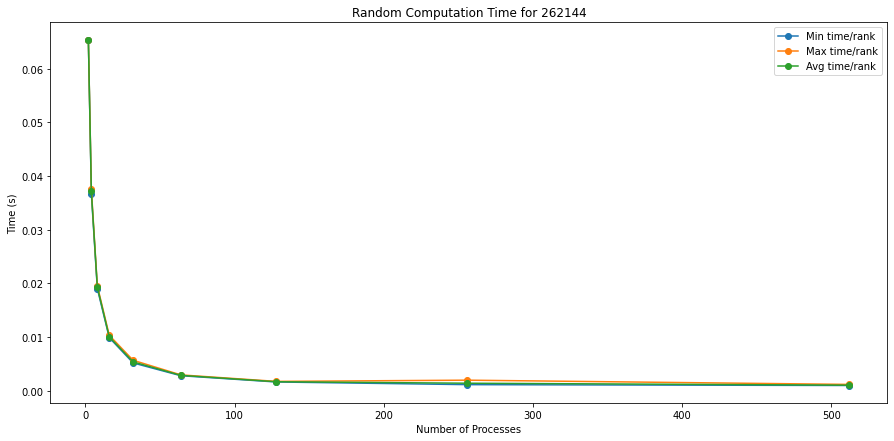

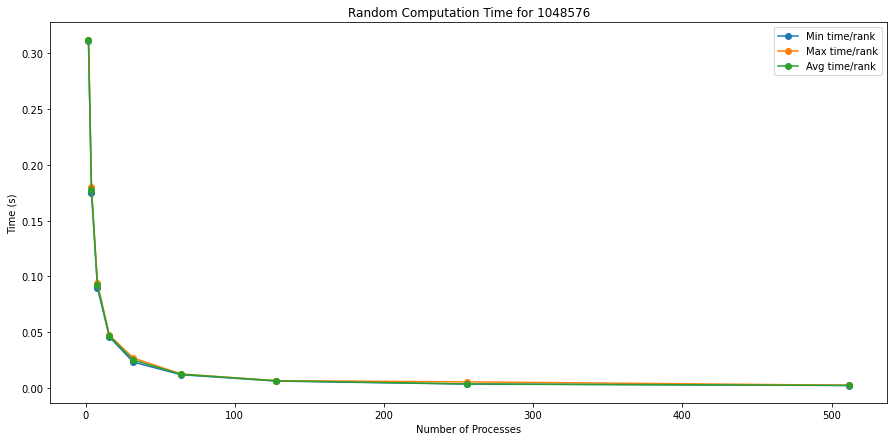

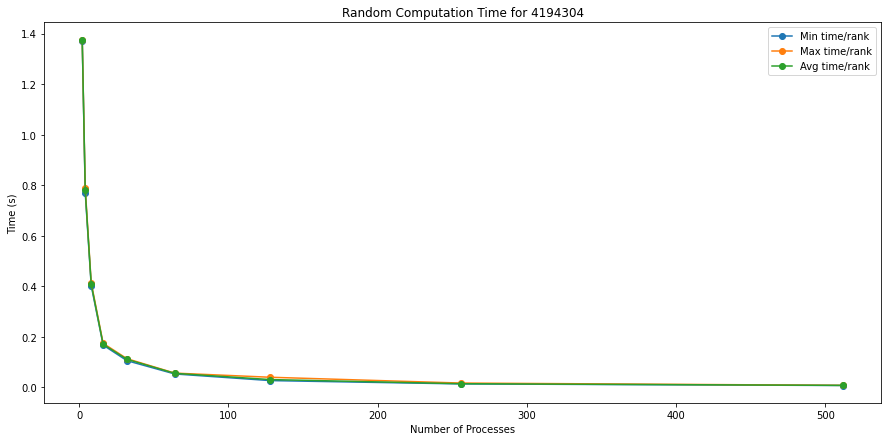

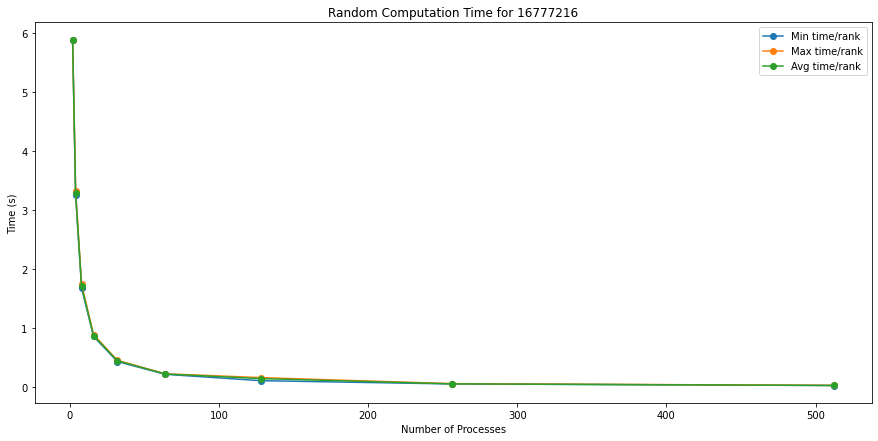

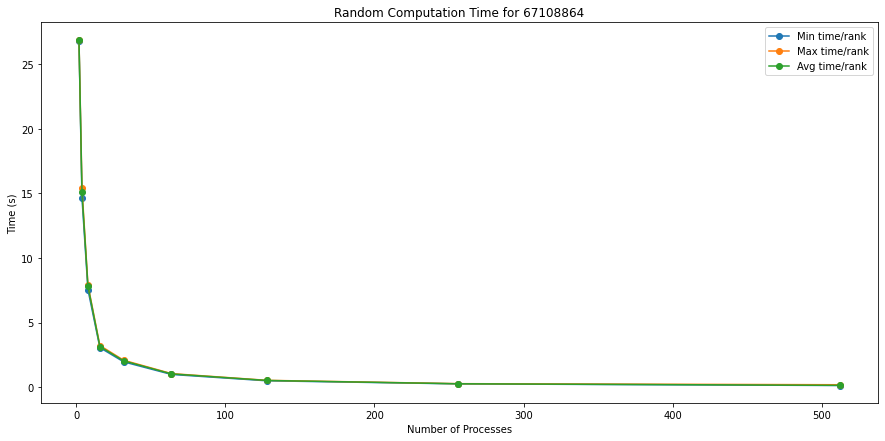

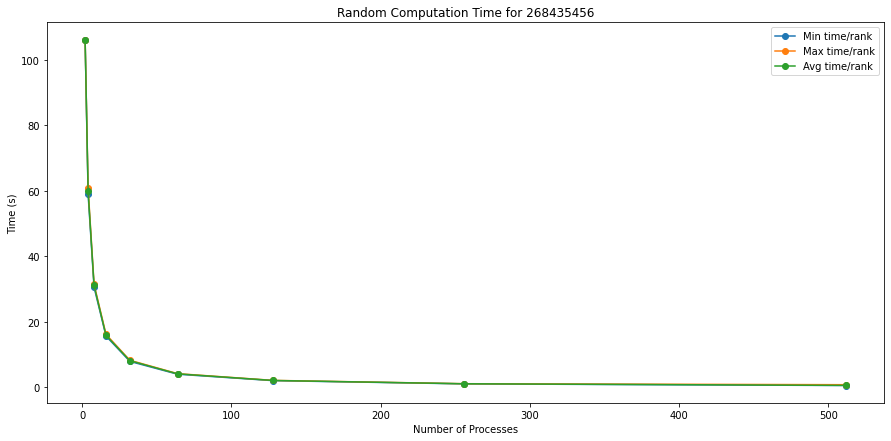

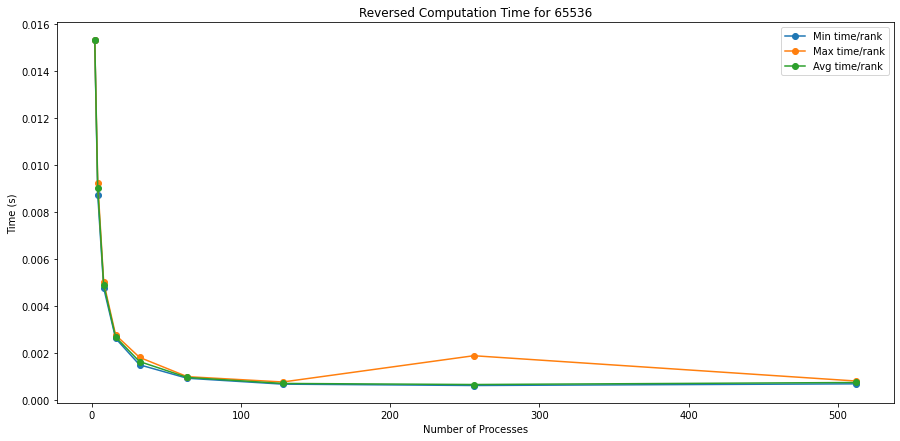

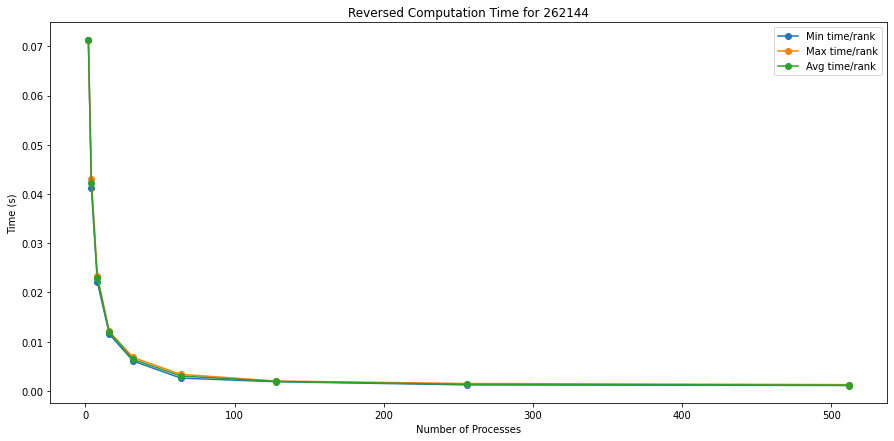

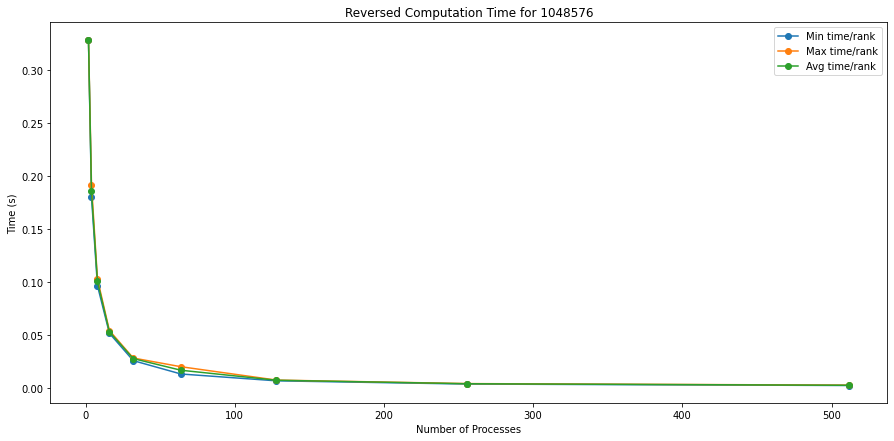

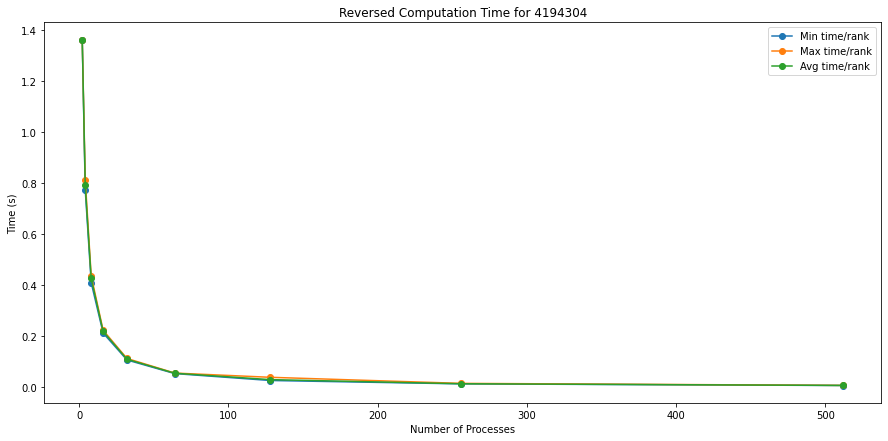

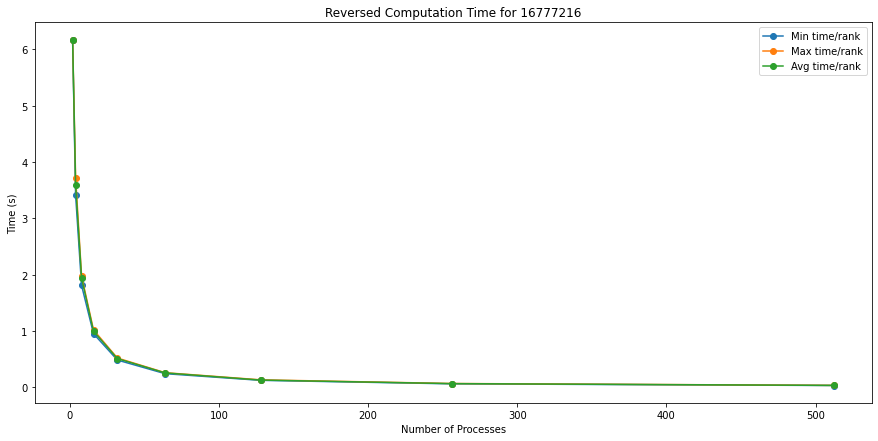

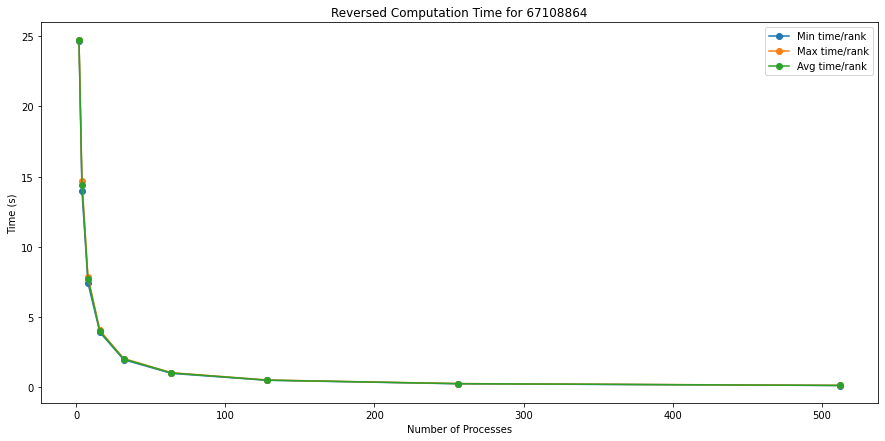

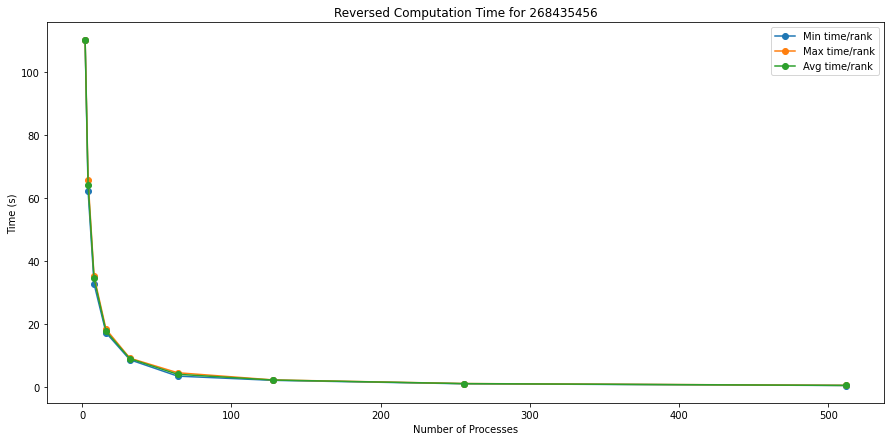

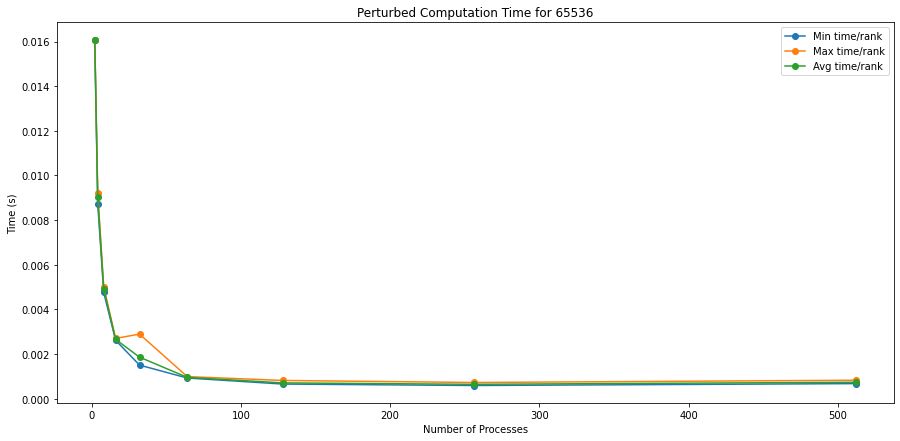

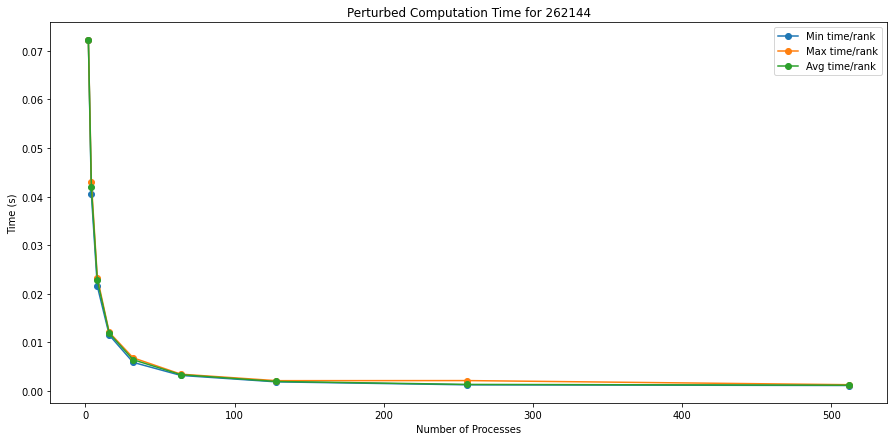

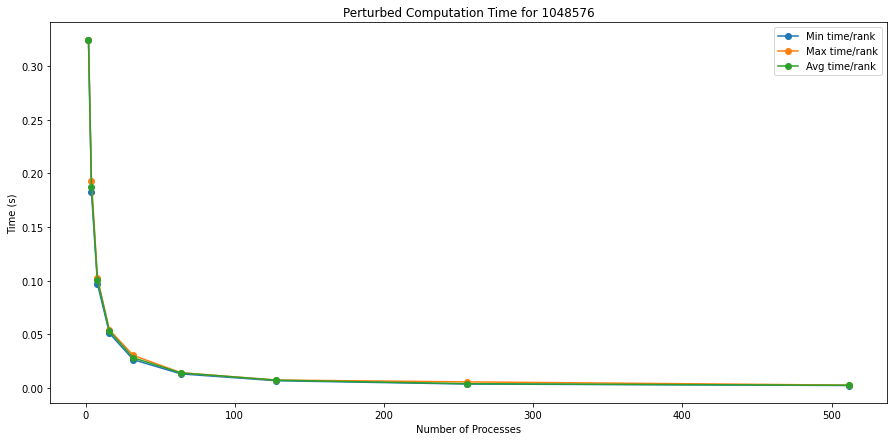

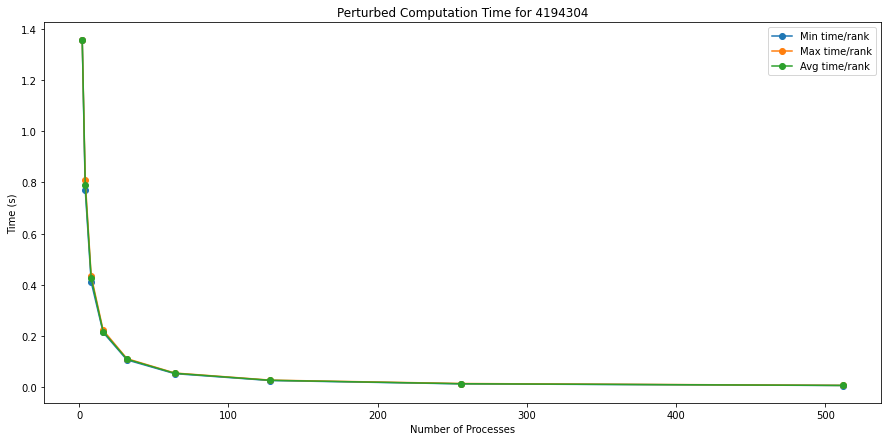

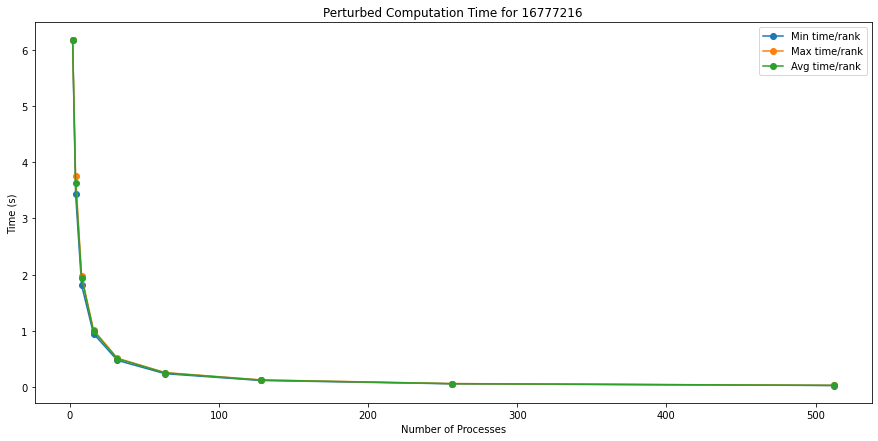

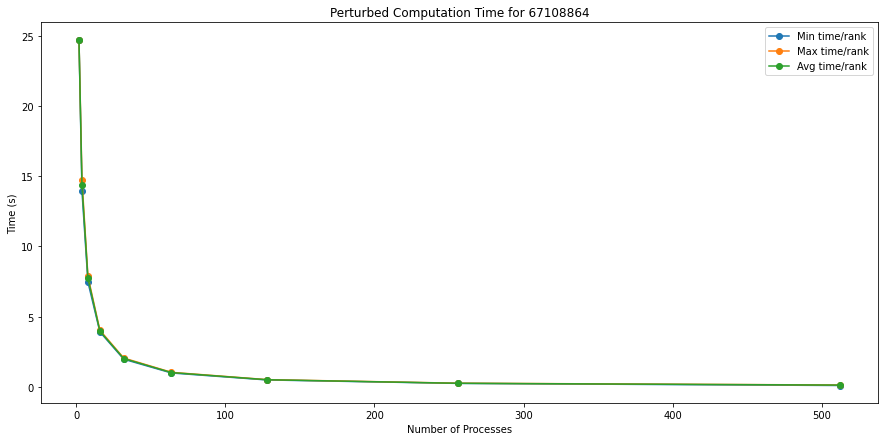

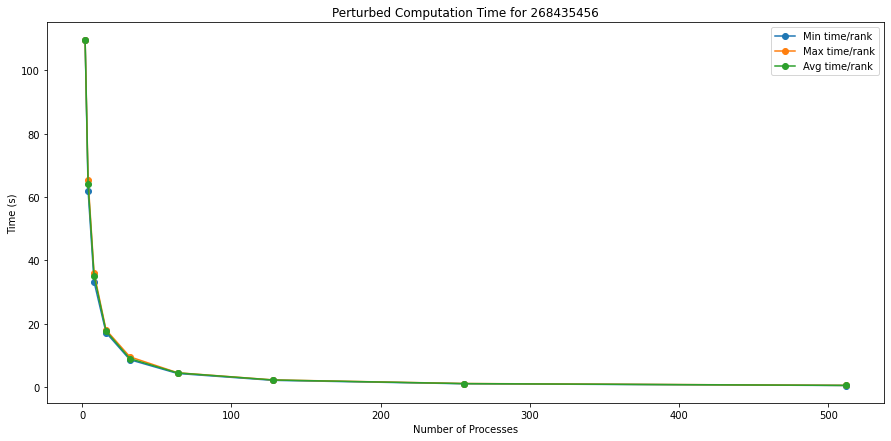

In [97]:
# Computation Time
# Sorted
for size in sizes:
    plot(in_order['comp'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Sorted Computation Time for {size}')

# Random
for size in sizes:
    plot(random['comp'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Random Computation Time for {size}')

# Reversed
for size in sizes:
    plot(reverse['comp'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Reversed Computation Time for {size}')
    
# Perturbed
for size in sizes:
    plot(pert['comp'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Perturbed Computation Time for {size}')

/tmp/job.11791231/ipykernel_4499/1250125561.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15, 7))


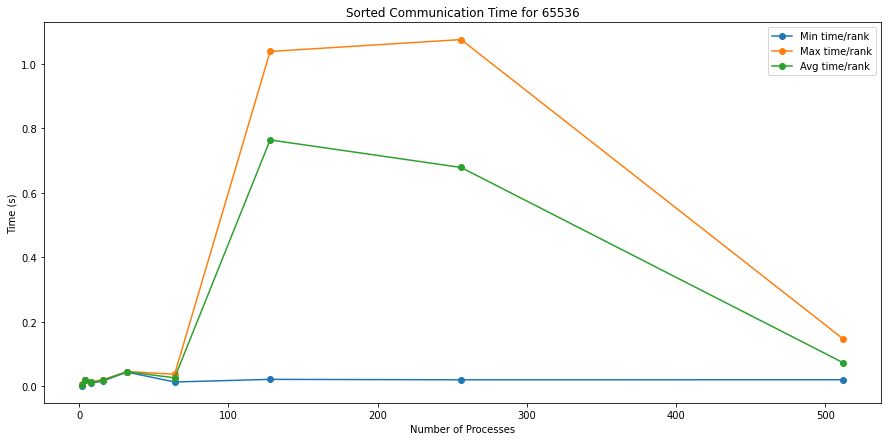

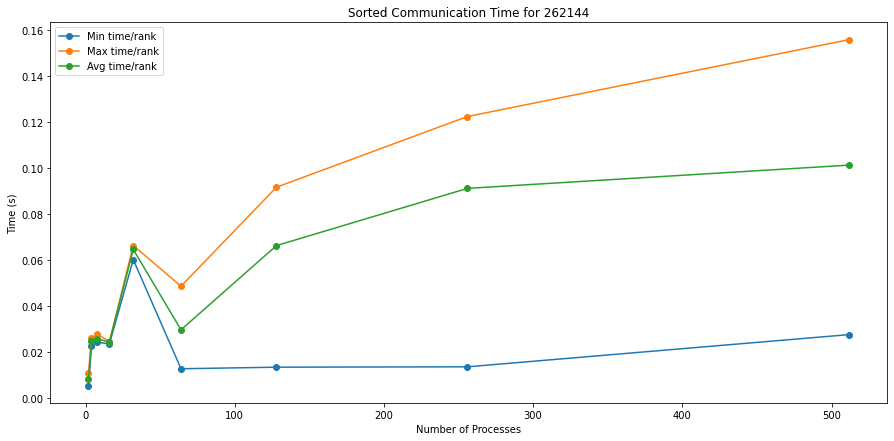

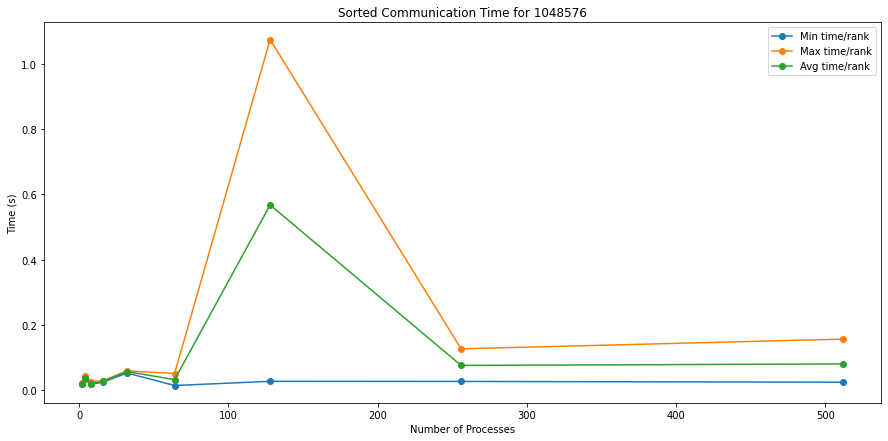

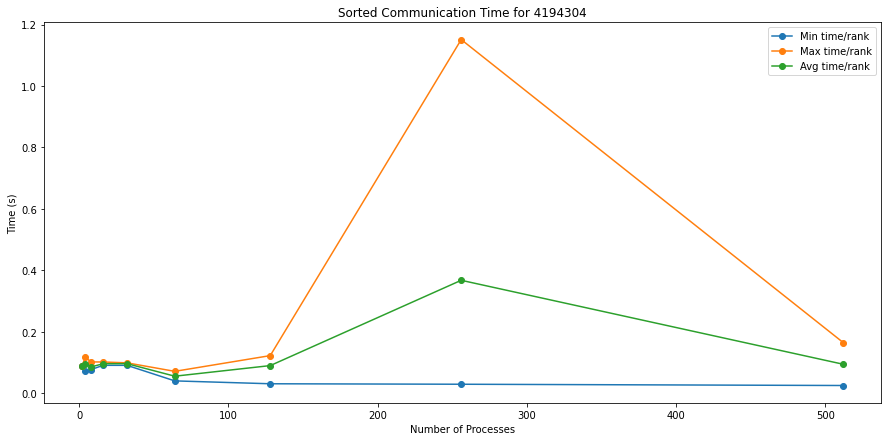

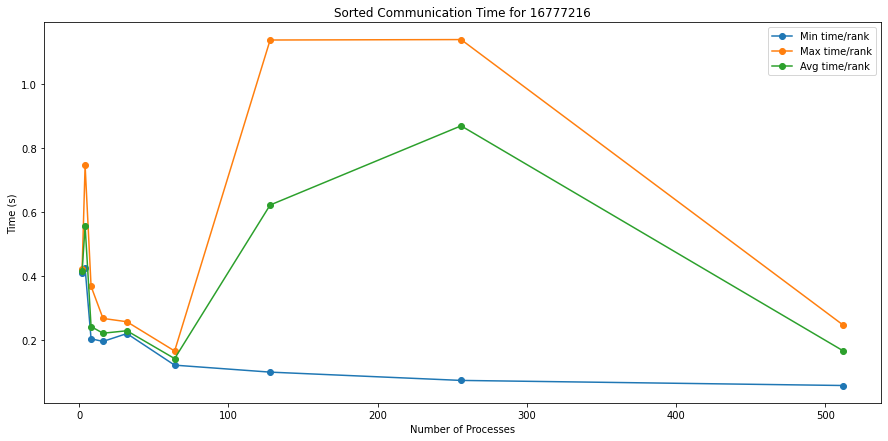

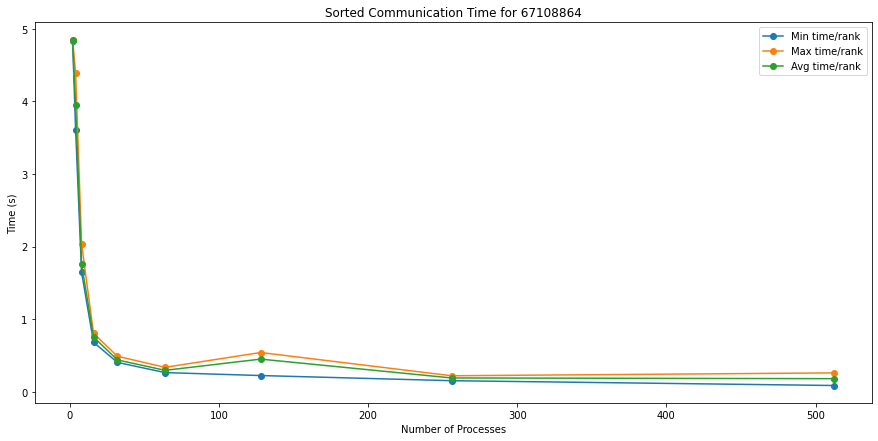

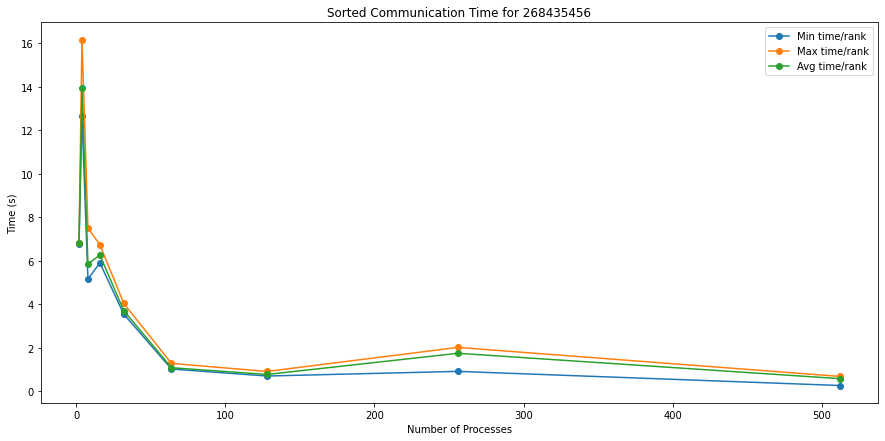

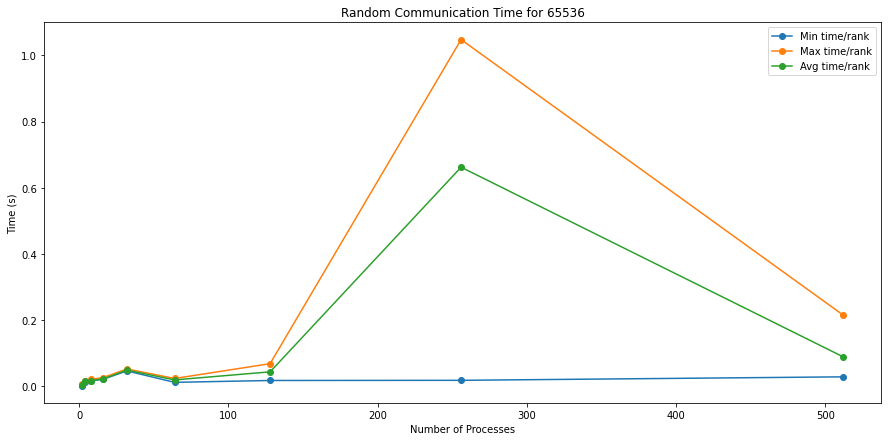

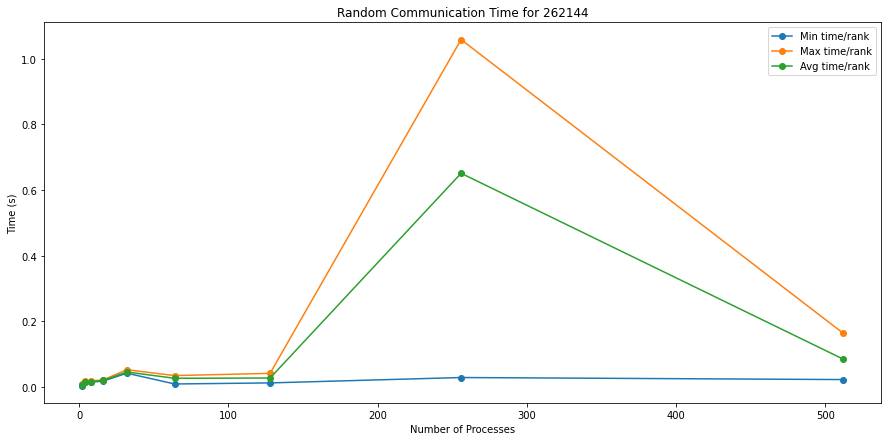

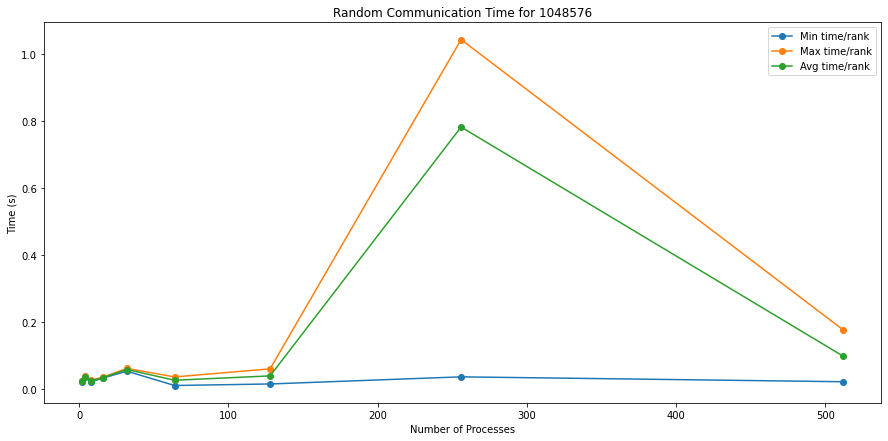

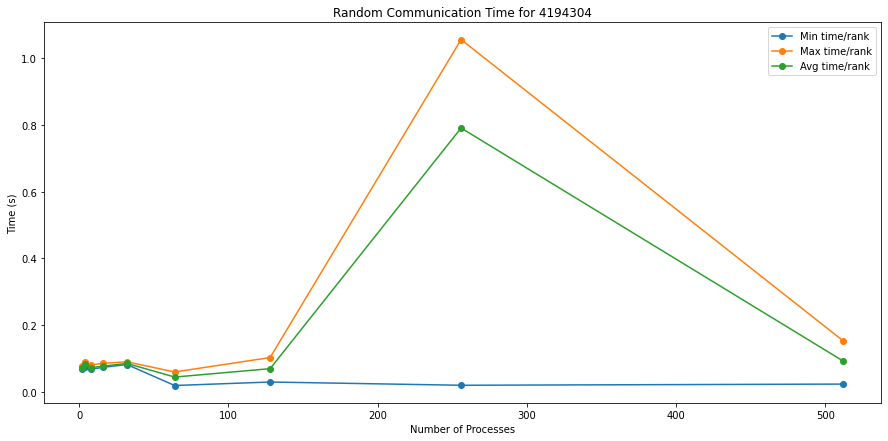

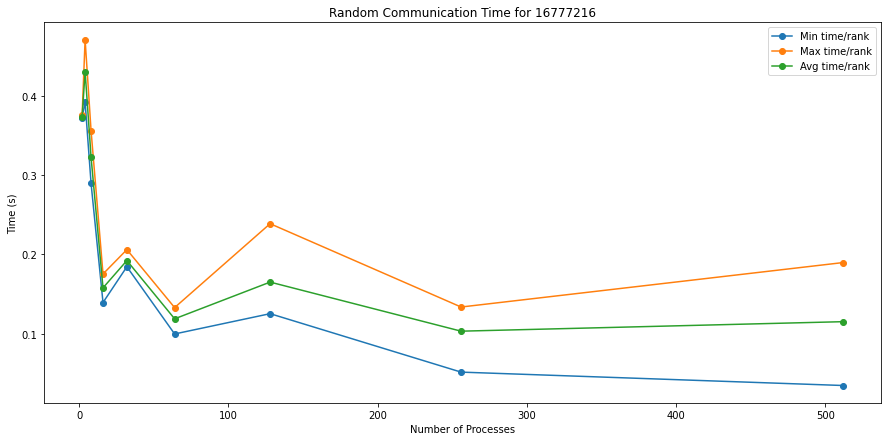

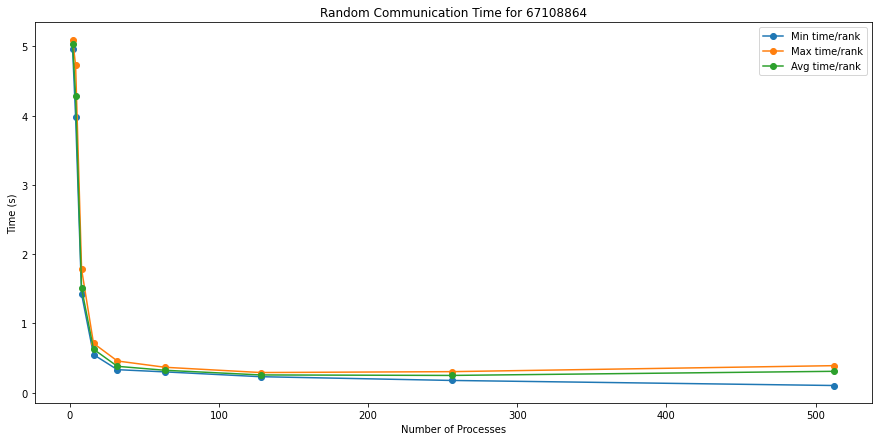

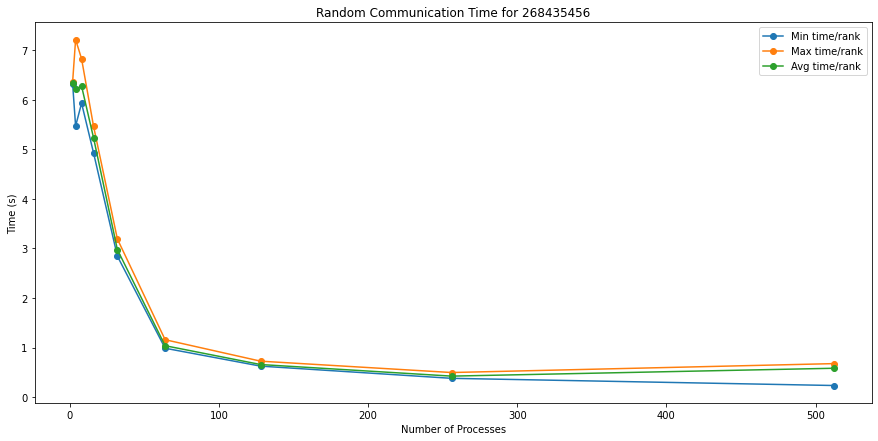

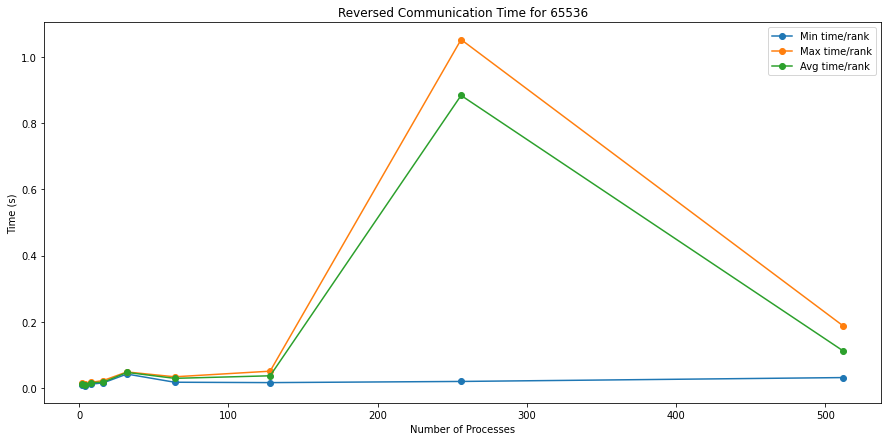

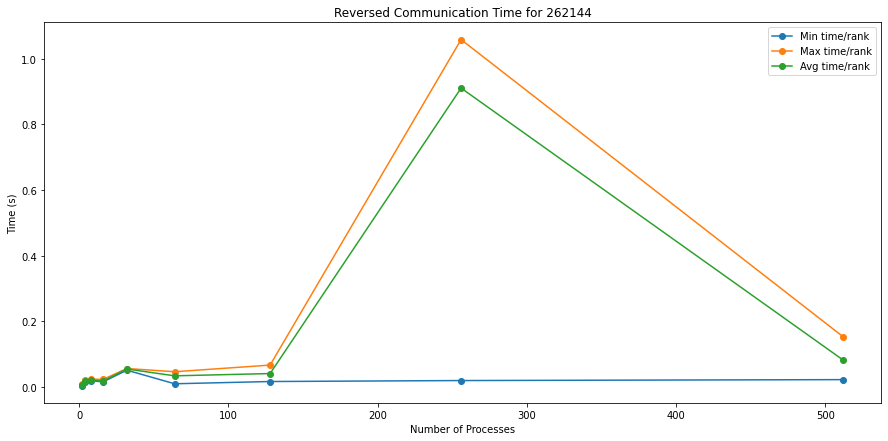

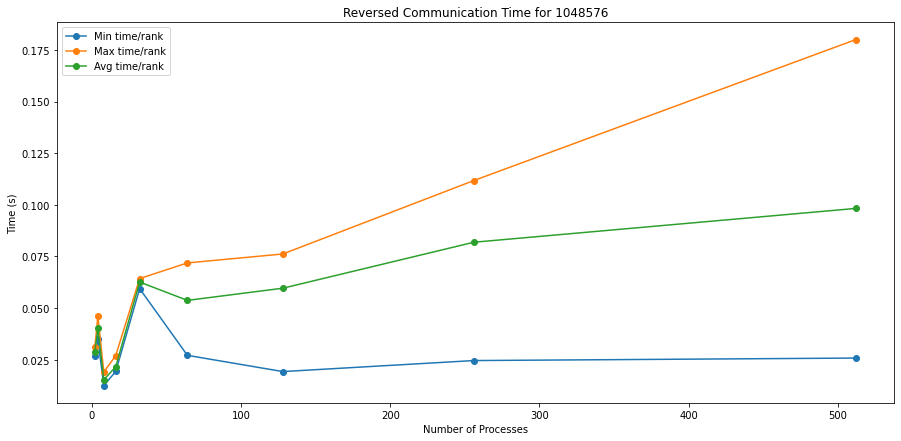

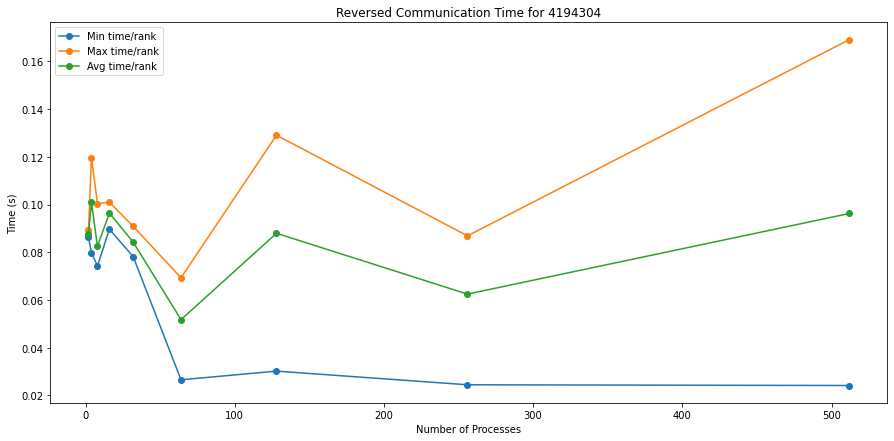

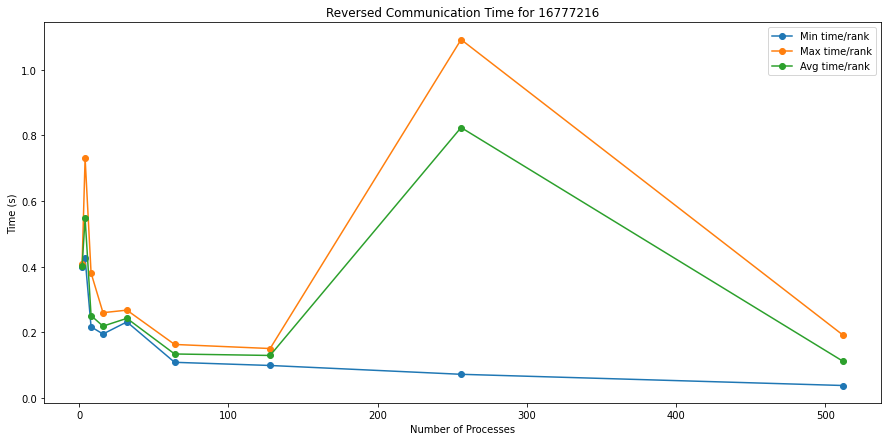

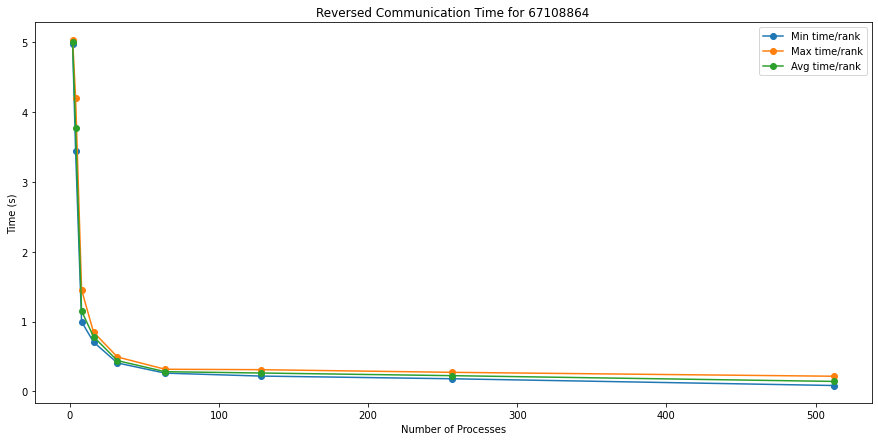

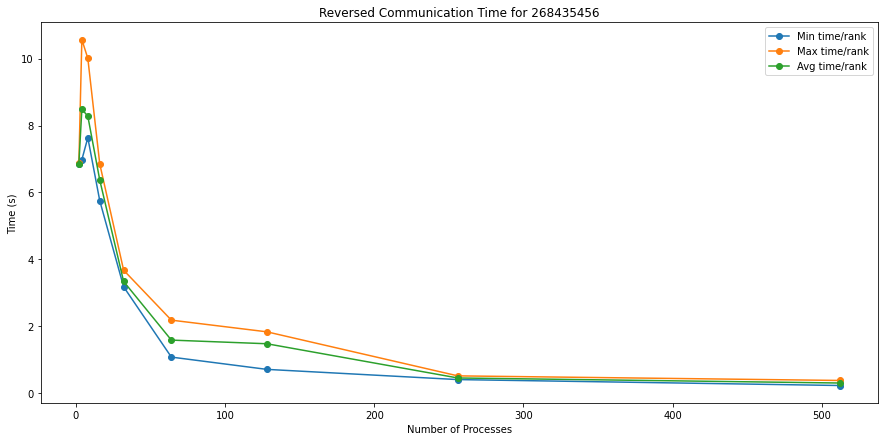

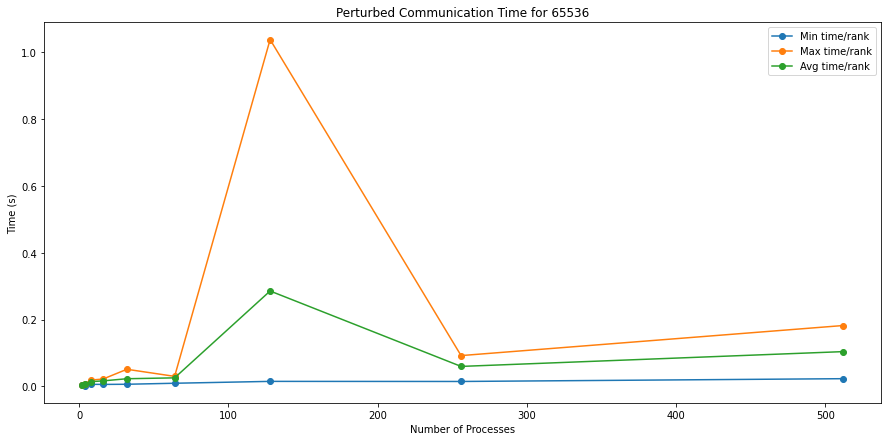

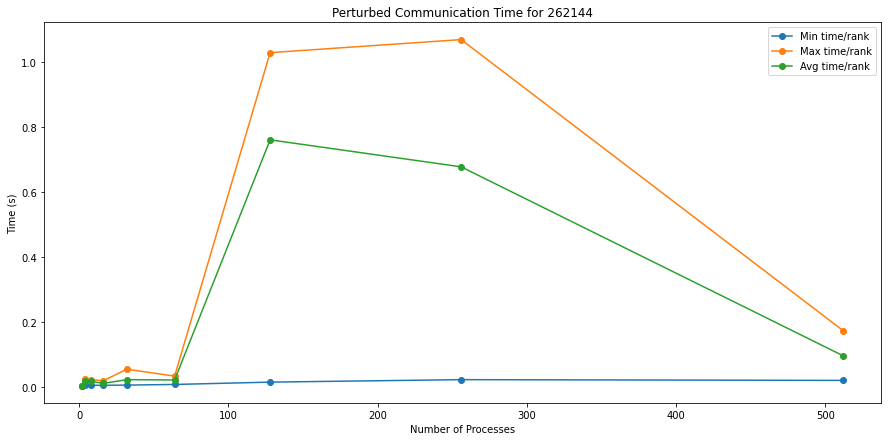

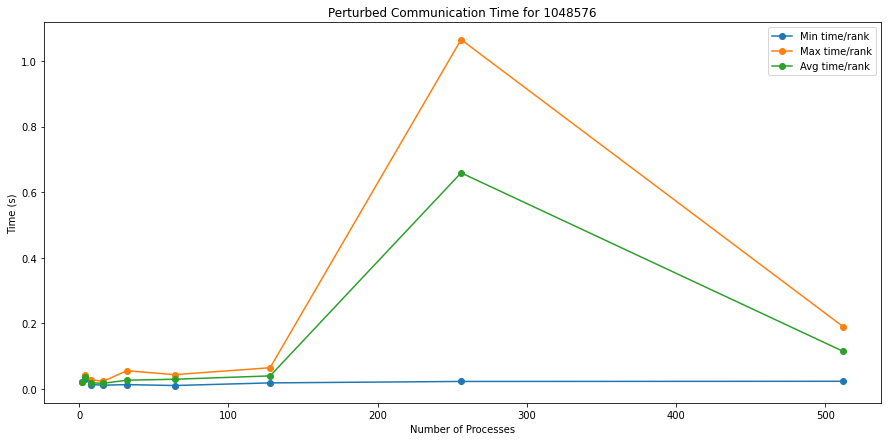

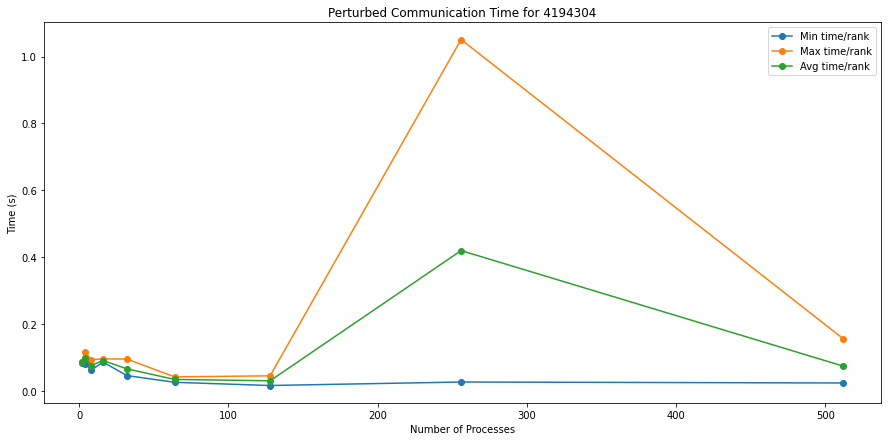

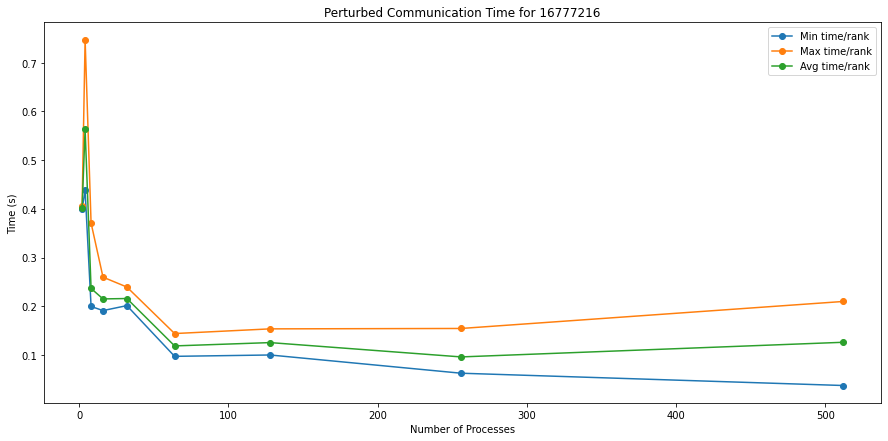

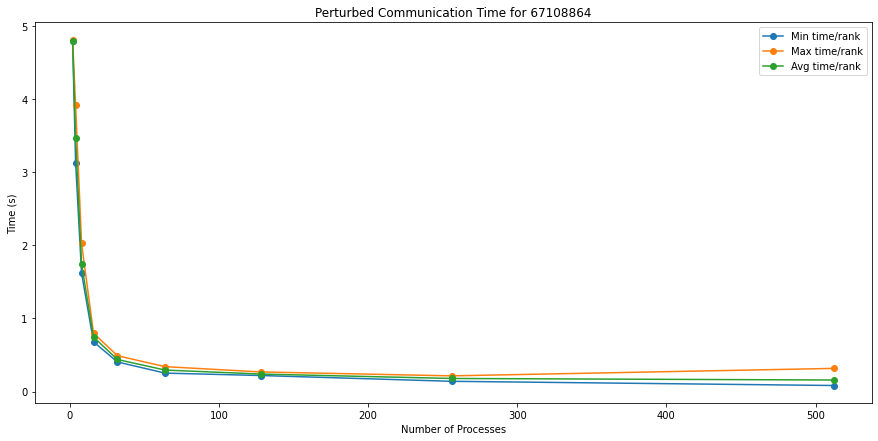

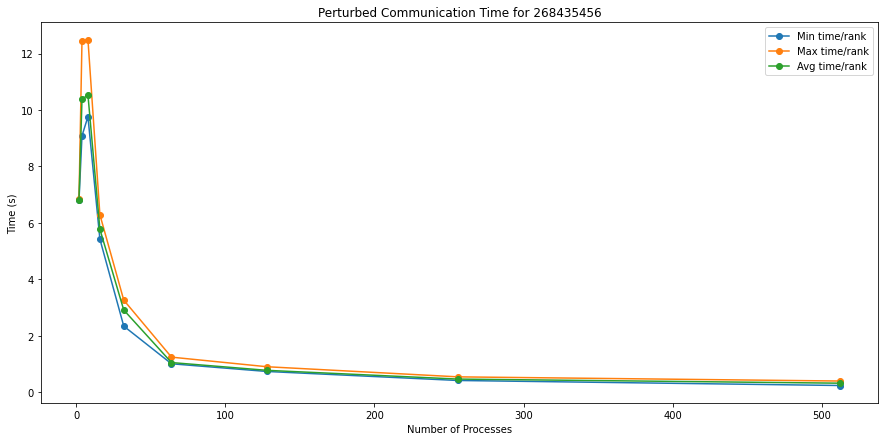

In [101]:
# Communication Time
# Sorted
for size in sizes:
    plot(in_order['comm'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Sorted Communication Time for {size}')

# Random
for size in sizes:
    plot(random['comm'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Random Communication Time for {size}')

# Reversed
for size in sizes:
    plot(reverse['comm'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Reversed Communication Time for {size}')
    
# Perturbed
for size in sizes:
    plot(pert['comm'][size], ['Min time/rank', 'Max time/rank', 'Avg time/rank'], f'Perturbed Communication Time for {size}')

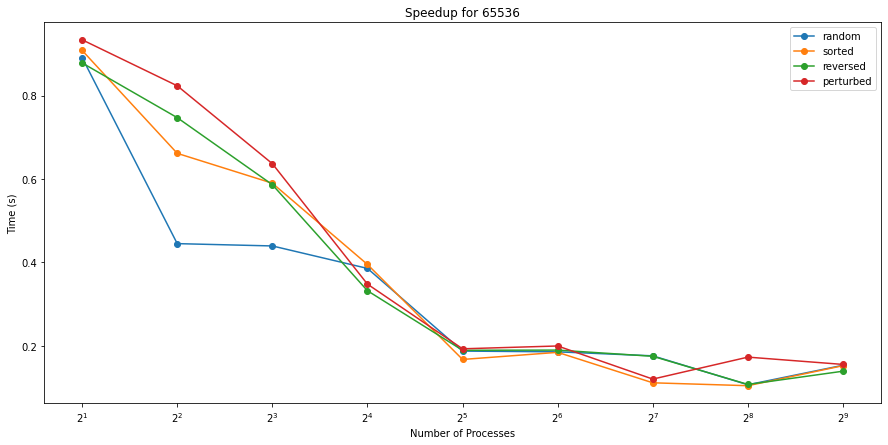

In [45]:
# Individual plots
size = 2**16 # Select Size (could iterate through if needed)

# Select which node, size, and measure
arr = {'random': random['speedup'][size][speedup_measurement],  
       'sorted': in_order['speedup'][size][speedup_measurement],
       'reversed': reverse['speedup'][size][speedup_measurement],
       'perturbed': pert['speedup'][size][speedup_measurement]
      }

n = ['random', 'sorted', 'reversed', 'perturbed']
plot(arr, n, f'Speedup for {size}')